# Diffuse 511 Spectral Fit in Galactic Coordinates

This notebook fits the spectrum for the 511 keV emission in the Galaxy. It can be used as a general template for fitting diffuse/extended sources in Galactic coordinates. For a general introduction into spectral fitting with cosipy, see the continuum_fit and line_fit tutorials.<br>

This notebook uses two 511 keV emission models, first a test model and then a realistic multi-component model. 

The test input model is available here: <br>
https://github.com/cositools/cosi-data-challenges/tree/main/cosi_dc/Source_Library/DC2/sources/511/511_Testing <br>
It is a toy 511 model, consisting of two components: an extended Gaussian source (5 degree extension) and a point source. In the first part of this tutorial, we fit the data with just the single extended Gaussian component, i.e. we ignore the point source component. This is done as a simplification, and as will be seen, it already provides a good fit. In the second part of this tutorial we use a model consisting of both components. 

The realistic input models are available here: <br>https://github.com/cositools/cosi-data-challenges/tree/main/cosi_dc/Source_Library/DC2/sources/511<br>
These are the realistic 511 models, consisting of a bulge component (with an extended Gaussian source and a point source) as well as a disk component with different spectral characteristics. In the third part of this tutorial we use this model. 

For the background we use just the cosmic photons. 

This tutotrial also walks through all the steps needed when performing a spectral fit, starting with the unbinned data, i.e. creating the combined data set, and binning the data. 

You will need the following files (available on wasabi):<br>
**20280301_3_month.ori <br>
cosmic_photons_3months_unbinned_data.fits.gz <br>
511_Testing_3months.fits.gz <br>
SMEXv12.511keV.HEALPixO4.binnedimaging.imagingresponse.nonsparse_nside16.area.h5 <br>
psr_gal_511_DC2.h5** <br>

The binned data products are available on wasabi (directory below), so you can also start by loading the binned data directly: <br>
COSI-SMEX/cosipy_tutorials/extended_source_spectral_fit_galactic_frame/

**WARNING:** If you run into memory issues creating the combined dataset or binning the data on your own, start by just loading the binned data directly. We are still working on optimizing the code, so please let us know if you run into these memory issues. <br>

In [1]:
# imports:
from cosipy import COSILike, test_data, BinnedData
from cosipy.spacecraftfile import SpacecraftFile
from cosipy.response.FullDetectorResponse import FullDetectorResponse
from scoords import SpacecraftFrame
from astropy.time import Time
import astropy.units as u
from astropy.coordinates import SkyCoord
from astromodels import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from threeML import PointSource, Model, JointLikelihood, DataList
from astromodels import Parameter
from astromodels import *
from mhealpy import HealpixMap, HealpixBase
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt 
from pathlib import Path
import os
import time
import h5py as h5
from histpy import Axis, Axes
import sys
from cosipy.response import PointSourceResponse
from histpy import Histogram

Welcome to JupyROOT 6.28/10


09:46:17 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=926496;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=405297;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#48\48]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=736780;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=675428;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#69\69]8;;\
                  will not be available.                                                                           

/home/field/COSItools_dev/python-env/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


09:46:18 WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=446206;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=525020;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py#33\33]8;;\
                  available                                                                                        

/home/field/COSItools_dev/python-env/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


09:46:18 INFO      Starting 3ML!                                                                     ]8;id=479310;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=135133;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py#35\35]8;;\

         WARNING   WARNINGs here are NOT errors                                                      ]8;id=584464;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=852186;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py#36\36]8;;\

         WARNING   but are inform you about optional packages that can be installed                  ]8;id=525846;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=571582;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py#37\37]8;;\

         WARNING    to disable these messages, turn off start_warning in your config file            ]8;id=878768;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=906491;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py#40\40]8;;\

09:46:19 WARNING   Multinest minimizer not available                                           ]8;id=285395;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=439086;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1357\1357]8;;\

         WARNING   PyGMO is not available                                                      ]8;id=451309;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=428498;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1369\1369]8;;\

09:46:19 WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=761991;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=283916;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py#94\94]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=223964;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=995392;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   Could not import plugin FermiLATLike.py. Do you have the relative instrument     ]8;id=12572;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=772939;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

09:46:20 WARNING   No fermitools installed                                              ]8;id=372788;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=858672;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py#44\44]8;;\

09:46:20 WARNING   Env. variable OMP_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=371313;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=794036;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable MKL_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=149951;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=422355;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable NUMEXPR_NUM_THREADS is not set. Please set it to 1 for optimal     ]8;id=434858;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=734220;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

## Get the data
The data can be downloaded directly from wasabi, or you can copy them by running the cells below. Each respective cell also gives the path to the file, in case you are looking for the location on wasabi. 

In [14]:
wasabi_stem = "AWS_ACCESS_KEY_ID=GBAL6XATQZNRV3GFH9Y4 AWS_SECRET_ACCESS_KEY=GToOczY5hGX3sketNO2fUwiq4DJoewzIgvTCHoOv aws s3api get-object  --bucket cosi-pipeline-public --key "
wasabi_url=' --endpoint-url=https://s3.us-west-1.wasabisys.com '

In [15]:
# ori file:
wasabi_path = "COSI-SMEX/DC2/Data/Orientation/20280301_3_month.ori"
print (wasabi_stem+wasabi_path+wasabi_url+wasabi_path.split("/")[-1])
os.system(wasabi_stem+wasabi_path+wasabi_url+wasabi_path.split("/")[-1])

AWS_ACCESS_KEY_ID=GBAL6XATQZNRV3GFH9Y4 AWS_SECRET_ACCESS_KEY=GToOczY5hGX3sketNO2fUwiq4DJoewzIgvTCHoOv aws s3api get-object  --bucket cosi-pipeline-public --key COSI-SMEX/DC2/Data/Orientation/20280301_3_month.ori --endpoint-url=https://s3.us-west-1.wasabisys.com 20280301_3_month.ori


0

{
    "AcceptRanges": "bytes",
    "LastModified": "2023-11-13T18:21:41+00:00",
    "ContentLength": 717627042,
    "ETag": "\"70746bdc382aed526bc4686d4cba062d-8\"",
    "ContentType": "application/octet-stream; charset=UTF-8",
    "Metadata": {}
}


In [29]:
# cosmic photons:
wasabi_path="COSI-SMEX/DC2/Data/Backgrounds/cosmic_photons_3months_unbinned_data.fits.gz"
print (wasabi_stem+wasabi_path+wasabi_url+wasabi_path.split("/")[-1])
os.system(wasabi_stem+wasabi_path+wasabi_url+wasabi_path.split("/")[-1])

AWS_ACCESS_KEY_ID=GBAL6XATQZNRV3GFH9Y4 AWS_SECRET_ACCESS_KEY=GToOczY5hGX3sketNO2fUwiq4DJoewzIgvTCHoOv aws s3api get-object  --bucket cosi-pipeline-public --key COSI-SMEX/DC2/Data/Backgrounds/cosmic_photons_3months_unbinned_data.fits.gz --endpoint-url=https://s3.us-west-1.wasabisys.com cosmic_photons_3months_unbinned_data.fits.gz


0

{
    "AcceptRanges": "bytes",
    "LastModified": "2023-10-23T21:13:54+00:00",
    "ContentLength": 9170101849,
    "ETag": "\"4095028bf091b423f757d40cfb026c41-92\"",
    "ContentType": "application/x-gzip; charset=UTF-8",
    "Metadata": {}
}


In [21]:
# 511 test model:
wasabi_path='COSI-SMEX/DC2/Data/Sources/511_Testing_3months_unbinned_data.fits.gz'
print (wasabi_stem+wasabi_path+wasabi_url+wasabi_path.split("/")[-1])
os.system(wasabi_stem+wasabi_path+wasabi_url+wasabi_path.split("/")[-1])

AWS_ACCESS_KEY_ID=GBAL6XATQZNRV3GFH9Y4 AWS_SECRET_ACCESS_KEY=GToOczY5hGX3sketNO2fUwiq4DJoewzIgvTCHoOv aws s3api get-object  --bucket cosi-pipeline-public --key COSI-SMEX/DC2/Data/Sources/511_Testing_3months_unbinned_data.fits.gz --endpoint-url=https://s3.us-west-1.wasabisys.com 511_Testing_3months_unbinned_data.fits.gz


0

{
    "AcceptRanges": "bytes",
    "LastModified": "2023-12-01T17:54:41+00:00",
    "ContentLength": 891954350,
    "ETag": "\"375a6fdc2fbfe39df13c37238c5ace30-9\"",
    "ContentType": "application/x-gzip; charset=UTF-8",
    "Metadata": {}
}


In [19]:
# detector response:
wasabi_path='COSI-SMEX/DC2/Responses/SMEXv12.511keV.HEALPixO4.binnedimaging.imagingresponse.nonsparse_nside16.area.h5'
print (wasabi_stem+wasabi_path+wasabi_url+wasabi_path.split("/")[-1])
os.system(wasabi_stem+wasabi_path+wasabi_url+wasabi_path.split("/")[-1])

AWS_ACCESS_KEY_ID=GBAL6XATQZNRV3GFH9Y4 AWS_SECRET_ACCESS_KEY=GToOczY5hGX3sketNO2fUwiq4DJoewzIgvTCHoOv aws s3api get-object  --bucket cosi-pipeline-public --key COSI-SMEX/DC2/Responses/SMEXv12.511keV.HEALPixO4.binnedimaging.imagingresponse.nonsparse_nside16.area.h5 --endpoint-url=https://s3.us-west-1.wasabisys.com SMEXv12.511keV.HEALPixO4.binnedimaging.imagingresponse.nonsparse_nside16.area.h5


0

{
    "AcceptRanges": "bytes",
    "LastModified": "2023-11-15T18:21:47+00:00",
    "ContentLength": 367447268,
    "ETag": "\"613e9a7056e9a034a327c9cf4782100a-4\"",
    "ContentType": "application/octet-stream; charset=UTF-8",
    "Metadata": {}
}


In [5]:
# point source response:
wasabi_path='COSI-SMEX/DC2/Responses/PointSourceReponse/psr_gal_511_DC2.h5.gz'
print (wasabi_stem+wasabi_path+wasabi_url+wasabi_path.split("/")[-1])
os.system(wasabi_stem+wasabi_path+wasabi_url+wasabi_path.split("/")[-1])
os.system("gzip -d "+wasabi_path.split("/")[-1])

0

{
    "AcceptRanges": "bytes",
    "LastModified": "2023-11-28T21:34:53+00:00",
    "ContentLength": 4099576756,
    "ETag": "\"609cd093d031854d1f81da9a1026acbd-41\"",
    "ContentType": "application/x-gzip; charset=UTF-8",
    "Metadata": {}
}


In [20]:
# Binned data products:
wasabi_path ='COSI-SMEX/cosipy_tutorials/extended_source_spectral_fit_galactic_frame'
file_list = ['cosmic_photons_binned_data.hdf5','gal_511_binned_data.hdf5','combined_binned_data.hdf5']

for each in file_list:
    print (wasabi_stem+wasabi_path+each+wasabi_url+each)
    os.system(wasabi_stem+wasabi_path+each+wasabi_url+each)

AWS_ACCESS_KEY_ID=GBAL6XATQZNRV3GFH9Y4 AWS_SECRET_ACCESS_KEY=GToOczY5hGX3sketNO2fUwiq4DJoewzIgvTCHoOv aws s3api get-object  --bucket cosi-pipeline-public --key COSI-SMEX/cosipy_tutorials/extended_source_spectral_fit_galactic_frame/cosmic_photons_binned_data.hdf5 --endpoint-url=https://s3.us-west-1.wasabisys.com cosmic_photons_binned_data.hdf5
AWS_ACCESS_KEY_ID=GBAL6XATQZNRV3GFH9Y4 AWS_SECRET_ACCESS_KEY=GToOczY5hGX3sketNO2fUwiq4DJoewzIgvTCHoOv aws s3api get-object  --bucket cosi-pipeline-public --key COSI-SMEX/cosipy_tutorials/extended_source_spectral_fit_galactic_frame/gal_511_binned_data.hdf5 --endpoint-url=https://s3.us-west-1.wasabisys.com gal_511_binned_data.hdf5
AWS_ACCESS_KEY_ID=GBAL6XATQZNRV3GFH9Y4 AWS_SECRET_ACCESS_KEY=GToOczY5hGX3sketNO2fUwiq4DJoewzIgvTCHoOv aws s3api get-object  --bucket cosi-pipeline-public --key COSI-SMEX/cosipy_tutorials/extended_source_spectral_fit_galactic_frame/combined_binned_data.hdf5 --endpoint-url=https://s3.us-west-1.wasabisys.com combined_binned_d

## Create the combined data
We will combine the 511 source and the cosmic photon background, which will be used as our dataset. <br>
This only needs to be done once.<br>
You can skip this cell if you already have the combined data file.

In [114]:
# Define instance of binned data class:
instance = BinnedData("Gal_511.yaml")

# Combine files:
input_files = ["cosmic_photons_3months_unbinned_data.fits.gz","511_Testing_3months_unbinned_data.fits.gz"]
instance.combine_unbinned_data(input_files, output_name="combined_data")


adding cosmic_photons_3months_unbinned_data.fits.gz...


adding 511_Testing_3months_unbinned_data.fits.gz...



## Bin the data 
You only have to do this once, and after you can start by loading the binned data directly. <br>
You can skip this cell if you already have the binned data files.

In [116]:
# Bin 511:
gal_511 = BinnedData("Gal_511.yaml")
gal_511.get_binned_data(unbinned_data="511_Testing_3months_unbinned_data.fits.gz", output_name="gal_511_binned_data")

binning data...
Time unit: s
Em unit: keV
Phi unit: deg
PsiChi unit: None


In [4]:
# Bin background:
bg_tot = BinnedData("Gal_511.yaml")
bg_tot.get_binned_data(unbinned_data="cosmic_photons_3months_unbinned_data.fits.gz", output_name="cosmic_photons_binned_data")

binning data...
Time unit: s
Em unit: keV
Phi unit: deg
PsiChi unit: None


In [117]:
# Bin combined data:
data_combined = BinnedData("Gal_511.yaml")
data_combined.get_binned_data(unbinned_data="combined_data.fits.gz", output_name="combined_binned_data")

binning data...
Time unit: s
Em unit: keV
Phi unit: deg
PsiChi unit: None


## Read in the binned data
Once you have the binned data files, you can start by loading them directly (instead of binning them each time).

In [2]:
# Load 511:
gal_511 = BinnedData("Gal_511.yaml")
gal_511.load_binned_data_from_hdf5(binned_data="gal_511_binned_data.hdf5")

# Load background:
bg_tot = BinnedData("Gal_511.yaml")
bg_tot.load_binned_data_from_hdf5(binned_data="cosmic_photons_binned_data.hdf5")

# Load combined data:
data_combined = BinnedData("Gal_511.yaml")
data_combined.load_binned_data_from_hdf5(binned_data="combined_binned_data.hdf5")

## Define Source
The injected source has both an extended componenent and a point source component, <br>
but to start with we will ignore the point source component, <br>
and see how well we can describe the data with just the extended component. <br>
Define the extended source:

In [3]:
# Define spectrum:
# Note that the units of the Gaussian function below are [F/sigma]=[ph/cm2/s/keV]
F = 4e-2 / u.cm / u.cm / u.s  
mu = 511*u.keV
sigma = 0.85*u.keV
spectrum = Gaussian()
spectrum.F.value = F.value
spectrum.F.unit = F.unit
spectrum.mu.value = mu.value
spectrum.mu.unit = mu.unit
spectrum.sigma.value = sigma.value
spectrum.sigma.unit = sigma.unit

# Set spectral parameters for fitting:
spectrum.F.free = True
spectrum.mu.free = True
spectrum.sigma.free = False

# Define morphology:
morphology = Gaussian_on_sphere(lon0 = 359.75, lat0 = -1.25, sigma = 5)

# Set morphological parameters for fitting:
morphology.lon0.free = False
morphology.lat0.free = False
morphology.sigma.free = False

# Define source:
src1 = ExtendedSource('gaussian', spectral_shape=spectrum, spatial_shape=morphology)

# Print a summary of the source info:
src1.display()

# We can also print the source info as follows.
# This will show you which parameters are free. 
#print(src1.spectrum.main.shape)
#print(src1.spatial_shape)

* gaussian (extended source):
    * shape:
      * lon0:
        * value: 359.75
        * desc: Longitude of the center of the source
        * min_value: 0.0
        * max_value: 360.0
        * unit: deg
        * is_normalization: false
      * lat0:
        * value: -1.25
        * desc: Latitude of the center of the source
        * min_value: -90.0
        * max_value: 90.0
        * unit: deg
        * is_normalization: false
      * sigma:
        * value: 5.0
        * desc: Standard deviation of the Gaussian distribution
        * min_value: 0.0
        * max_value: 20.0
        * unit: deg
        * is_normalization: false
    * spectrum:
      * main:
        * Gaussian:
          * F:
            * value: 0.04
            * desc: Integral between -inf and +inf. Fix this to 1 to obtain a Normal distribution
            * min_value: null
            * max_value: null
            * unit: s-1 cm-2
            * is_normalization: false
          * mu:
            * value: 511.0
            * desc: Central value
            * min_value: null
            * max_value: null
            * unit: keV
            * is_normalization: false
          * sigma:
            * value: 0.85
            * desc: standard deviation
            * min_value: 1.0e-12
            * max_value: null
            * unit: keV
            * is_normalization: false
        * polarization: {}

Let's make some plots to look at the extended source:

Text(0.5, 0, 'Energy [keV]')

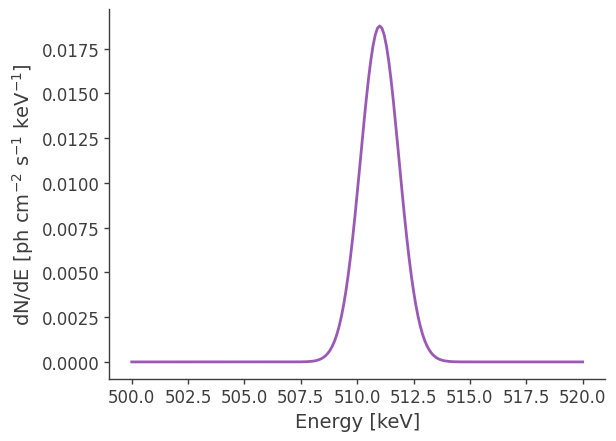

In [4]:
# Plot spectrum:
energy = np.linspace(500.,520.,201)*u.keV
dnde = src1.spectrum.main.Gaussian(energy)
plt.plot(energy, dnde)
plt.ylabel("dN/dE [$\mathrm{ph \ cm^{-2} \ s^{-1} \ keV^{-1}}$]", fontsize=14)
plt.xlabel("Energy [keV]", fontsize=14);

An extended source in astromodels corresponds to a skymap, which is normalized so that the sum over the entire sky, multiplied by the pixel area, equals 1. The pixel values in the skymap serve as weights, which we can use to scale the input spectrum, in order to get the model counts for any location on the sky. This is all handled internally within cosipy, but for demonstration purposes, let's take a look at the skymap:

In [5]:
# Define healpix map matching the detector response:
skymap = HealpixMap(nside = 16, scheme = "ring", dtype = float, coordsys='G')
coords1 = skymap.pix2skycoord(range(skymap.npix))
pix_area = skymap.pixarea().value

# Fill skymap with values from extended source: 
skymap[:] = src1.Gaussian_on_sphere(coords1.l.deg, coords1.b.deg) 

# Check normalization:
print("summed map: " + str(np.sum(skymap)*pix_area))

summed map: 0.9974653836229357


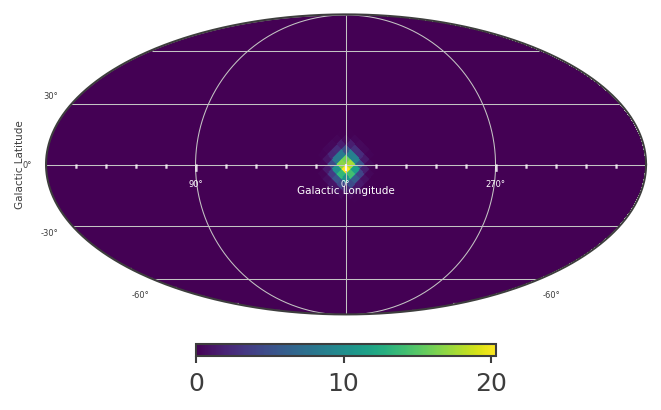

In [6]:
# Plot healpix map:
plot, ax = skymap.plot(ax_kw = {'coord':'G'})
ax.grid()
lon = ax.coords['glon']
lat = ax.coords['glat']
lon.set_axislabel('Galactic Longitude',color='white',fontsize=5)
lat.set_axislabel('Galactic Latitude',fontsize=5)
lon.display_minor_ticks(True)
lat.display_minor_ticks(True)
lon.set_ticks_visible(True)
lon.set_ticklabel_visible(True)
lon.set_ticks(color='white',alpha=0.6)
lat.set_ticks(color='white',alpha=0.6)
lon.set_ticklabel(color='white',fontsize=4)
lat.set_ticklabel(fontsize=4)
lat.set_ticks_visible(True)
lat.set_ticklabel_visible(True)

(1e-50, 1)

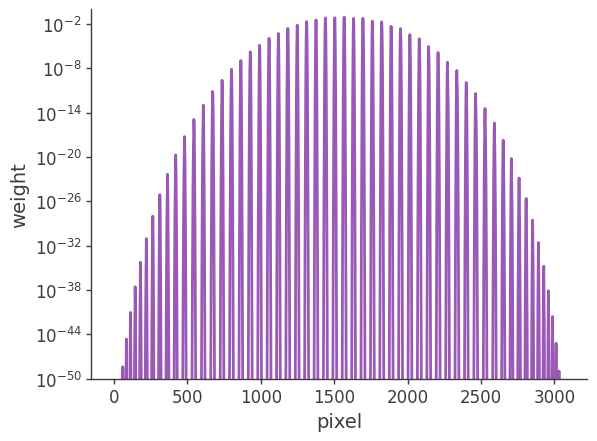

In [7]:
# Plot weights directly
# Note: for extended sources the weights also need to include the pixel area.
plt.semilogy(skymap[:]*pix_area)
plt.ylabel("weight")
plt.xlabel("pixel")
plt.ylim(1e-50,1);

## Setup the COSI 3ML plugin and Perform the Likelihood Fit
Load the detector response, ori file, and precomputed point source response in Galactic coordinates:

In [8]:
response_file = "SMEXv12.511keV.HEALPixO4.binnedimaging.imagingresponse.nonsparse_nside16.area.h5"
response = FullDetectorResponse.open(response_file)
ori = SpacecraftFile.parse_from_file("20280301_3_month.ori")
psr_file = "psr_gal_511_DC2.h5"

Setup the COSI 3ML plugin:

In [9]:
# Set background parameter, which is used to fit the amplitude of the background:
bkg_par = Parameter("background_cosi",                                        # background parameter
                    1,                                                        # initial value of parameter
                    min_value=0,                                              # minimum value of parameter
                    max_value=5,                                              # maximum value of parameter
                    delta=0.05,                                               # initial step used by fitting engine
                    desc="Background parameter for cosi")

# Instantiate the COSI 3ML plugin
cosi = COSILike("cosi",                                                       # COSI 3ML plugin
                dr = response_file,                                           # detector response
                data = data_combined.binned_data.project('Em', 'Phi', 'PsiChi'),       # data (source+background)
                bkg = bg_tot.binned_data.project('Em', 'Phi', 'PsiChi'),          # background model 
                sc_orientation = ori,                                          # spacecraft orientation
                nuisance_param = bkg_par,                                      # background parameter
                precomputed_psr_file = psr_file)                               # full path to precomputed psr file in galactic coordinates (optional)
                 
# Add sources to model:
model = Model(src1)  # Model with single source. If we had multiple sources, we would do Model(source1, source2, ...)

... loading the pre-computed image response ...
--> done


Perform likelihood fit: 

In [12]:
plugins = DataList(cosi) # If we had multiple instruments, we would do e.g. DataList(cosi, lat, hawc, ...)

like = JointLikelihood(model, plugins, verbose = False)

like.fit()

10:06:34 INFO      set the minimizer to minuit                                             ]8;id=617946;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=502315;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\


WARNING RuntimeWarning: invalid value encountered in log



10:09:41 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=280057;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=523319;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#130\130]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

Best fit values:

,result,unit
parameter,,
gaussian.spectrum.main.Gaussian.F,(4.695 +/- 0.033) x 10^-2,1 / (s cm2)
gaussian.spectrum.main.Gaussian.mu,(5.110 +/- 0.005) x 10^2,keV
background_cosi,(9.32 +/- 0.05) x 10^-1,


Correlation matrix:

1.00,1.00,-0.01
1.00,1.00,0.02
-0.01,0.02,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,-1.527559e+07
total,-1.527559e+07


Values of statistical measures:

,statistical measures
AIC,-3.055119e+07
BIC,-3.055119e+07


(                                         value  negative_error  \
 gaussian.spectrum.main.Gaussian.F     0.046951       -0.000332   
 gaussian.spectrum.main.Gaussian.mu  510.999885       -0.459983   
 background_cosi                       0.932127       -0.004774   
 
                                     positive_error     error         unit  
 gaussian.spectrum.main.Gaussian.F         0.000333  0.000332  1 / (s cm2)  
 gaussian.spectrum.main.Gaussian.mu        0.465312  0.462648          keV  
 background_cosi                           0.004723  0.004749               ,
        -log(likelihood)
 cosi      -1.527559e+07
 total     -1.527559e+07)

## Results
First, let's just print the results. <br>

In [13]:
results = like.results
results.display()

# Print a summary of the optimized model:
print(results.optimized_model["gaussian"])

Best fit values:

,result,unit
parameter,,
gaussian.spectrum.main.Gaussian.F,(4.695 +/- 0.033) x 10^-2,1 / (s cm2)
gaussian.spectrum.main.Gaussian.mu,(5.110 +/- 0.005) x 10^2,keV
background_cosi,(9.32 +/- 0.05) x 10^-1,


Correlation matrix:

1.00,1.00,-0.01
1.00,1.00,0.02
-0.01,0.02,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,-1.527559e+07
total,-1.527559e+07


Values of statistical measures:

,statistical measures
AIC,-3.055119e+07
BIC,-3.055119e+07


  * gaussian (extended source):
    * shape:
      * lon0:
        * value: 359.75
        * desc: Longitude of the center of the source
        * min_value: 0.0
        * max_value: 360.0
        * unit: deg
        * is_normalization: false
      * lat0:
        * value: -1.25
        * desc: Latitude of the center of the source
        * min_value: -90.0
        * max_value: 90.0
        * unit: deg
        * is_normalization: false
      * sigma:
        * value: 5.0
        * desc: Standard deviation of the Gaussian distribution
        * min_value: 0.0
        * max_value: 20.0
        * unit: deg
        * is_normalization: false
    * spectrum:
      * main:
        * Gaussian:
          * F:
            * value: 0.046951067636512224
            * desc: Integral between -inf and +inf. Fix this to 1 to obtain a Normal distribution
            * min_value: null
            * max_value: null
            * unit: s-1 cm-2
            * is_normalization: false
          * mu:
       

Now let's make some plots. <br>
Let's first look at the best-fit spectrum:

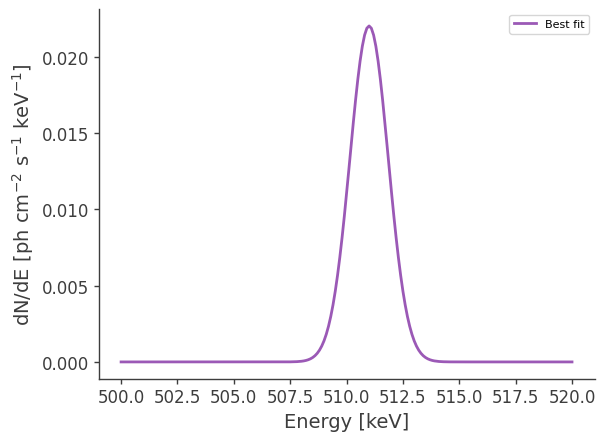

In [14]:
# Best-fit model:
energy = np.linspace(500.,520.,201)*u.keV
flux = results.optimized_model["gaussian"].spectrum.main.shape(energy)

fig,ax = plt.subplots()

ax.plot(energy, flux, label = "Best fit")


plt.ylabel("dN/dE [$\mathrm{ph \ cm^{-2} \ s^{-1} \ keV^{-1}}$]", fontsize=14)
plt.xlabel("Energy [keV]", fontsize=14)
ax.legend()

Now let's compare the predicted counts to the injected counts:

Error: [2129.0618147]


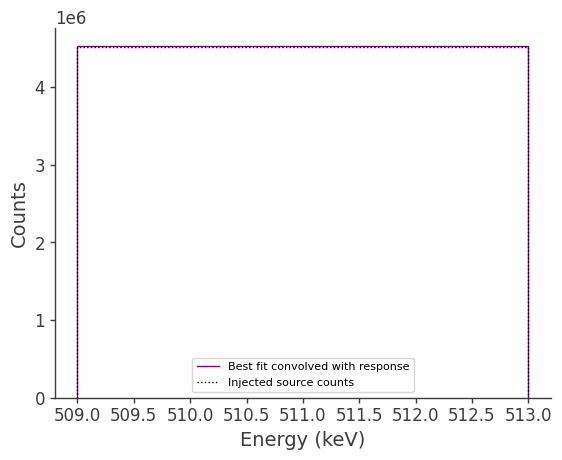

In [15]:
# Get expected counts from likelihood scan (i.e. best-fit convolved with response):
total_expectation = cosi._expected_counts['gaussian']

# Plot:       
fig,ax = plt.subplots()

binned_energy_edges = gal_511.binned_data.axes['Em'].edges.value
binned_energy = gal_511.binned_data.axes['Em'].centers.value

ax.stairs(total_expectation.project('Em').todense().contents, binned_energy_edges, color='purple', label = "Best fit convolved with response")
ax.errorbar(binned_energy, total_expectation.project('Em').todense().contents, yerr=np.sqrt(total_expectation.project('Em').todense().contents), color='purple', linewidth=0, elinewidth=1)
ax.stairs(gal_511.binned_data.project('Em').todense().contents, binned_energy_edges, color = 'black', ls = ":", label = "Injected source counts")
ax.errorbar(binned_energy, gal_511.binned_data.project('Em').todense().contents, yerr=np.sqrt(gal_511.binned_data.project('Em').todense().contents), color='black', linewidth=0, elinewidth=1)

ax.set_xlabel("Energy (keV)")
ax.set_ylabel("Counts")

ax.legend()

# Note: We are plotting the error, but it's very small:
print("Error: " +str(np.sqrt(total_expectation.project('Em').todense().contents)))

Let's also compare the projection onto Psichi:

Text(0.5, 1.0, 'injected counts')

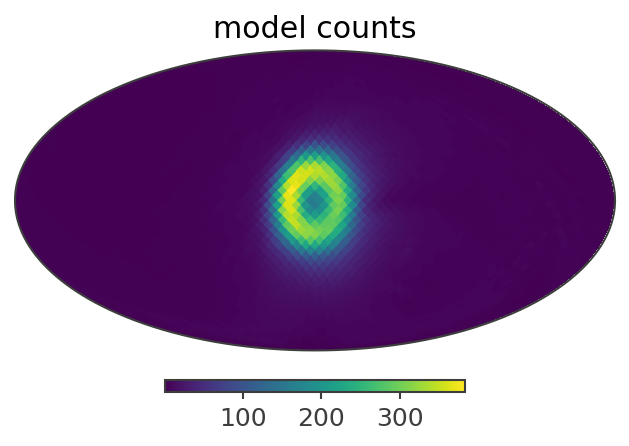

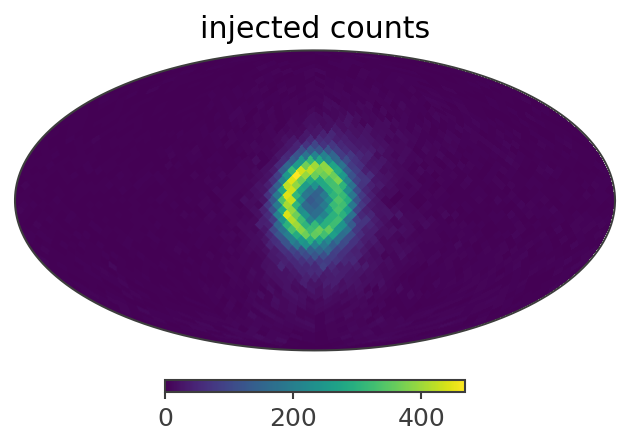

In [16]:
# expected src counts:
ax,plot = total_expectation.slice[{'Em':0, 'Phi':5}].project('PsiChi').plot(ax_kw = {'coord':'G'})
plt.title("model counts")

# injected src counts:
ax,plot = gal_511.binned_data.slice[{'Em':0, 'Phi':5}].project('PsiChi').plot(ax_kw = {'coord':'G'})
plt.title("injected counts")

Here is a summary of the results:

Injected model (extended source): <br>
F = 4e-2 ph/cm2/s <br>
mu = 511 keV <br>

Best-fit: <br>
F = (4.695 +/- 0.033)e-2 ph/cm2/s <br>
mu = 511.0 +/- 0.5 keV <br>

We see that the best-fit values are very close to the injected values. The small difference is likely due to the fact that the injected model also has a point source component (which we've ignored), having the same specrtum, with a normalization of F = 1e-2 ph/cm2/s. In the next example we'll see if this point source component can be detected. 

# **********************************************************
## Perform Analysis with Two Components

Define the point source. <br>
We'll add this to the model, and keep just the normalization free.

In [17]:
# Note: Astromodels only takes ra,dec for point source input:
c = SkyCoord(l=0*u.deg, b=0*u.deg, frame='galactic')
c_icrs = c.transform_to('icrs')

# Define spectrum:
# Note that the units of the Gaussian function below are [F/sigma]=[ph/cm2/s/keV]
F = 1e-2 / u.cm / u.cm / u.s  
Fmin = 0 / u.cm / u.cm / u.s
Fmax = 1 / u.cm / u.cm / u.s
mu = 511*u.keV
sigma = 0.85*u.keV
spectrum2 = Gaussian()
spectrum2.F.value = F.value
spectrum2.F.unit = F.unit
spectrum2.F.min_value = Fmin.value
spectrum2.F.max_value = Fmax.value
spectrum2.mu.value = mu.value
spectrum2.mu.unit = mu.unit
spectrum2.sigma.value = sigma.value
spectrum2.sigma.unit = sigma.unit

# Set spectral parameters for fitting:
spectrum2.F.free = True
spectrum2.mu.free = False
spectrum2.sigma.free = False

# Define source:
src2 = PointSource('point_source', ra = c_icrs.ra.deg, dec = c_icrs.dec.deg, spectral_shape=spectrum2)

# Print some info about the source just as a sanity check.
# This will also show you which parameters are free. 
print(src2.spectrum.main.shape)

# We can also get a summary of the source info as follows:
#src2.display()

  * description: A Gaussian function
  * formula: $ K \frac{1}{\sigma \sqrt{2 \pi}}\exp{\frac{(x-\mu)^2}{2~(\sigma)^2}} $
  * parameters:
    * F:
      * value: 0.01
      * desc: Integral between -inf and +inf. Fix this to 1 to obtain a Normal distribution
      * min_value: 0.0
      * max_value: 1.0
      * unit: s-1 cm-2
      * is_normalization: false
      * delta: 0.1
      * free: true
    * mu:
      * value: 511.0
      * desc: Central value
      * min_value: null
      * max_value: null
      * unit: keV
      * is_normalization: false
      * delta: 0.1
      * free: false
    * sigma:
      * value: 0.85
      * desc: standard deviation
      * min_value: 1.0e-12
      * max_value: null
      * unit: keV
      * is_normalization: false
      * delta: 0.1
      * free: false



Redefine the first source.<br> 
We'll keep just the normalization free. 

In [18]:
# Define spectrum:
# Note that the units of the Gaussian function below are [F/sigma]=[ph/cm2/s/keV]
F = 4e-2 / u.cm / u.cm / u.s 
Fmin = 0 / u.cm / u.cm / u.s
Fmax = 1 / u.cm / u.cm / u.s
mu = 511*u.keV
sigma = 0.85*u.keV
spectrum = Gaussian()
spectrum.F.value = F.value
spectrum.F.unit = F.unit
spectrum.F.min_value = Fmin.value
spectrum.F.max_value = Fmax.value
spectrum.mu.value = mu.value
spectrum.mu.unit = mu.unit
spectrum.sigma.value = sigma.value
spectrum.sigma.unit = sigma.unit

# Set spectral parameters for fitting:
spectrum.F.free = True
spectrum.mu.free = False
spectrum.sigma.free = False

# Define morphology:
morphology = Gaussian_on_sphere(lon0 = 359.75, lat0 = -1.25, sigma = 5)

# Set morphological parameters for fitting:
morphology.lon0.free = False
morphology.lat0.free = False
morphology.sigma.free = False

# Define source:
src1 = ExtendedSource('gaussian', spectral_shape=spectrum, spatial_shape=morphology)

# Print a summary of the source info:
src1.display()

# We can also print the source info as follows.
# This will also show you which parameters are free. 
#print(src1.spectrum.main.shape)
#print(src1.spatial_shape)

* gaussian (extended source):
    * shape:
      * lon0:
        * value: 359.75
        * desc: Longitude of the center of the source
        * min_value: 0.0
        * max_value: 360.0
        * unit: deg
        * is_normalization: false
      * lat0:
        * value: -1.25
        * desc: Latitude of the center of the source
        * min_value: -90.0
        * max_value: 90.0
        * unit: deg
        * is_normalization: false
      * sigma:
        * value: 5.0
        * desc: Standard deviation of the Gaussian distribution
        * min_value: 0.0
        * max_value: 20.0
        * unit: deg
        * is_normalization: false
    * spectrum:
      * main:
        * Gaussian:
          * F:
            * value: 0.04
            * desc: Integral between -inf and +inf. Fix this to 1 to obtain a Normal distribution
            * min_value: 0.0
            * max_value: 1.0
            * unit: s-1 cm-2
            * is_normalization: false
          * mu:
            * value: 511.0
            * desc: Central value
            * min_value: null
            * max_value: null
            * unit: keV
            * is_normalization: false
          * sigma:
            * value: 0.85
            * desc: standard deviation
            * min_value: 1.0e-12
            * max_value: null
            * unit: keV
            * is_normalization: false
        * polarization: {}

Setup the COSI 3ML plugin using two sources in the model:

In [19]:
# Set background parameter, which is used to fit the amplitude of the background:
bkg_par = Parameter("background_cosi",                                        # background parameter
                    1,                                                        # initial value of parameter
                    min_value=0,                                              # minimum value of parameter
                    max_value=5,                                              # maximum value of parameter
                    delta=0.05,                                               # initial step used by fitting engine
                    desc="Background parameter for cosi")

# Instantiate the COSI 3ML plugin
cosi = COSILike("cosi",                                                       # COSI 3ML plugin
                dr = response_file,                                           # detector response
                data = data_combined.binned_data.project('Em', 'Phi', 'PsiChi'),       # data (source+background)
                bkg = bg_tot.binned_data.project('Em', 'Phi', 'PsiChi'),          # background model 
                sc_orientation = ori,                                          # spacecraft orientation
                nuisance_param = bkg_par,                                      # background parameter
                precomputed_psr_file = psr_file)                               # full path to precomputed psr file in galactic coordinates (optional)
                 
# Add sources to model:
model = Model(src1, src2)  # Model with two sources.

... loading the pre-computed image response ...
--> done


Display the model:

In [21]:
model.display()

Model summary:
==============

                  N
Point sources     1
Extended sources  1
Particle sources  0

Free parameters (2):
--------------------

                                      value min_value max_value      unit
gaussian.spectrum.main.Gaussian.F      0.04       0.0       1.0  s-1 cm-2
point_source.spectrum.main.Gaussian.F  0.01       0.0       1.0  s-1 cm-2

Fixed parameters (9):
(abridged. Use complete=True to see all fixed parameters)


Properties (0):
--------------------

(none)


Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

Linked functions (0):
----------------------

(none)

Perform the likelihood fit:

In [22]:
start = time.time()

plugins = DataList(cosi) # If we had multiple instruments, we would do e.g. DataList(cosi, lat, hawc, ...)

like = JointLikelihood(model, plugins, verbose = True)

like.fit()

stop = time.time()
total_time = stop - start
print("processing time [min]: " + str(total_time/60.0))

... Calculating point source responses ...
--> done (source name : point_source)
--> all done


10:23:37 INFO      set the minimizer to minuit                                             ]8;id=474358;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=691555;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

10:23:38 INFO      trial values: 0.04,0.01,1 -> logL = 14908358.728                        ]8;id=529993;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=250526;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:23:40 INFO      trial values: 0.040804,0.01,1 -> logL = 14911295.359                    ]8;id=669379;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=752683;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:23:41 INFO      trial values: 0.039204,0.01,1 -> logL = 14904015.715                    ]8;id=566639;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=220839;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:23:42 INFO      trial values: 0.04008,0.01,1 -> logL = 14908715.495                     ]8;id=169717;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=885837;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:23:43 INFO      trial values: 0.03992,0.01,1 -> logL = 14907987.897                     ]8;id=770881;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=708212;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:23:44 INFO      trial values: 0.04,0.010201,1 -> logL = 14898734.111                    ]8;id=5216;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=429921;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:23:46 INFO      trial values: 0.04,0.009801,1 -> logL = 14917820.671                    ]8;id=29666;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=506096;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:23:47 INFO      trial values: 0.04,0.010042,1 -> logL = 14906360.208                    ]8;id=3743;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=335984;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:23:48 INFO      trial values: 0.04,0.0099582,1 -> logL = 14910350.138                   ]8;id=263193;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=195428;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:23:49 INFO      trial values: 0.04,0.01,1.0201 -> logL = 14907769.198                   ]8;id=766667;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=988591;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:23:51 INFO      trial values: 0.04,0.01,0.98007 -> logL = 14908928.814                  ]8;id=685760;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=751116;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:23:52 INFO      trial values: 0.04,0.01,1.0121 -> logL = 14908004.588                   ]8;id=197378;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=877932;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:23:53 INFO      trial values: 0.04,0.01,0.98793 -> logL = 14908705.758                  ]8;id=648700;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=167608;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:23:54 INFO      trial values: 0.042095,0.0016969,0.47859 -> logL = 15226326.006         ]8;id=843451;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=31265;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:23:55 INFO      trial values: 0.04229,0.0012799,0.43902 -> logL = 15232794.823          ]8;id=539888;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=74316;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:23:57 INFO      trial values: 0.042523,0.000861,0.39406 -> logL = 15237090.316          ]8;id=83550;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=580976;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:23:58 INFO      trial values: 0.042678,0.00062687,0.36521 -> logL = 15238270.567        ]8;id=209306;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=28187;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:23:59 INFO      trial values: 0.042738,0.00062687,0.36521 -> logL = 15238920.893        ]8;id=904550;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=175292;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:00 INFO      trial values: 0.042619,0.00062687,0.36521 -> logL = 15237612.079        ]8;id=801968;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=658462;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:01 INFO      trial values: 0.042678,0.00063755,0.36521 -> logL = 15238251.031        ]8;id=417889;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=95691;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:03 INFO      trial values: 0.042678,0.00061628,0.36521 -> logL = 15238287.734        ]8;id=233945;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=239163;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:04 INFO      trial values: 0.042678,0.00064563,0.36521 -> logL = 15238234.771        ]8;id=669391;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=129968;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:05 INFO      trial values: 0.042678,0.00060838,0.36521 -> logL = 15238299.096        ]8;id=137372;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=27726;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:06 INFO      trial values: 0.042678,0.00062687,0.3732 -> logL = 15238686.158         ]8;id=3665;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=546117;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:08 INFO      trial values: 0.042678,0.00062687,0.3573 -> logL = 15237853.117         ]8;id=291484;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=953932;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:09 INFO      trial values: 0.042678,0.00062687,0.3811 -> logL = 15239090.507         ]8;id=780847;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=773498;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:10 INFO      trial values: 0.042678,0.00062687,0.34964 -> logL = 15237443.362        ]8;id=363846;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=530272;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:11 INFO      trial values: 0.048599,0.0002466,0.8657 -> logL = 15271663.872          ]8;id=728253;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=65341;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:12 INFO      trial values: 0.047517,0.00030163,0.76339 -> logL = 15273594.939        ]8;id=234580;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=318447;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:14 INFO      trial values: 0.047576,0.00030163,0.76339 -> logL = 15273537.994        ]8;id=110082;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=433930;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:15 INFO      trial values: 0.047458,0.00030163,0.76339 -> logL = 15273645.122        ]8;id=249123;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=307217;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:16 INFO      trial values: 0.047517,0.0003147,0.76339 -> logL = 15273484.793         ]8;id=602245;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=894040;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:17 INFO      trial values: 0.047517,0.00028883,0.76339 -> logL = 15273699.130        ]8;id=972989;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=856754;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:18 INFO      trial values: 0.047517,0.00030163,0.78528 -> logL = 15273652.336        ]8;id=779324;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=94833;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:20 INFO      trial values: 0.047517,0.00030163,0.74174 -> logL = 15273511.259        ]8;id=821654;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=167296;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:21 INFO      trial values: 0.047517,0.00030163,0.77488 -> logL = 15273628.459        ]8;id=358842;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=221202;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:22 INFO      trial values: 0.047517,0.00030163,0.75196 -> logL = 15273554.136        ]8;id=574628;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=90933;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:23 INFO      trial values: 0.047263,0.00023218,0.83736 -> logL = 15274478.508        ]8;id=9666;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=256680;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:25 INFO      trial values: 0.046818,0.00013202,0.97403 -> logL = 15275112.491        ]8;id=678518;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=582757;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:26 INFO      trial values: 0.046879,0.00013202,0.97403 -> logL = 15275100.573        ]8;id=798598;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=12255;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:27 INFO      trial values: 0.046758,0.00013202,0.97403 -> logL = 15275117.124        ]8;id=528696;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=748558;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:28 INFO      trial values: 0.046818,0.00014165,0.97403 -> logL = 15275059.149        ]8;id=466636;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=477365;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:29 INFO      trial values: 0.046818,0.00012272,0.97403 -> logL = 15275161.495        ]8;id=485362;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=280640;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:31 INFO      trial values: 0.046818,0.00013202,0.98668 -> logL = 15275066.922        ]8;id=719114;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=307187;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:32 INFO      trial values: 0.046818,0.00013202,0.96144 -> logL = 15275149.774        ]8;id=419286;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=554834;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:33 INFO      trial values: 0.046781,9.8025e-05,0.94402 -> logL = 15275339.943        ]8;id=197097;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=726675;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:34 INFO      trial values: 0.046742,6.8231e-05,0.91341 -> logL = 15275432.185        ]8;id=962611;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=531925;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:35 INFO      trial values: 0.046737,6.4575e-05,0.90926 -> logL = 15275434.623        ]8;id=893926;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=369521;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:37 INFO      trial values: 0.046797,6.4575e-05,0.90926 -> logL = 15275455.595        ]8;id=34630;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=596563;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:38 INFO      trial values: 0.046676,6.4575e-05,0.90926 -> logL = 15275406.324        ]8;id=888064;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=54438;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:39 INFO      trial values: 0.046737,7.3438e-05,0.90926 -> logL = 15275412.007        ]8;id=412631;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=413152;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:40 INFO      trial values: 0.046737,5.6281e-05,0.90926 -> logL = 15275453.370        ]8;id=619629;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=560870;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:41 INFO      trial values: 0.046737,6.4575e-05,0.92081 -> logL = 15275445.583        ]8;id=917580;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=427666;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:43 INFO      trial values: 0.046737,6.4575e-05,0.89777 -> logL = 15275416.592        ]8;id=199220;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=621867;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:44 INFO      trial values: 0.046895,3.706e-05,0.92235 -> logL = 15275542.470         ]8;id=545577;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=536651;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:45 INFO      trial values: 0.046993,2.3897e-05,0.93044 -> logL = 15275563.633        ]8;id=632898;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=320521;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:46 INFO      trial values: 0.047054,2.3897e-05,0.93044 -> logL = 15275552.836        ]8;id=608934;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=109202;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:47 INFO      trial values: 0.046932,2.3897e-05,0.93044 -> logL = 15275567.167        ]8;id=471731;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=792264;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:49 INFO      trial values: 0.046993,3.1596e-05,0.93044 -> logL = 15275549.674        ]8;id=923580;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=556524;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:50 INFO      trial values: 0.046993,1.7272e-05,0.93044 -> logL = 15275573.841        ]8;id=984773;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=454143;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:51 INFO      trial values: 0.046993,2.3897e-05,0.94227 -> logL = 15275555.189        ]8;id=216789;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=549220;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:52 INFO      trial values: 0.046993,2.3897e-05,0.91866 -> logL = 15275564.690        ]8;id=166199;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=557129;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:53 INFO      trial values: 0.046971,1.4613e-05,0.93088 -> logL = 15275579.115        ]8;id=834506;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=858169;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:55 INFO      trial values: 0.046944,6.3454e-06,0.93143 -> logL = 15275588.809        ]8;id=679262;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=915653;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:56 INFO      trial values: 0.046932,3.7175e-06,0.93168 -> logL = 15275590.799        ]8;id=93491;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=336521;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:57 INFO      trial values: 0.046922,2.0723e-06,0.93188 -> logL = 15275591.595        ]8;id=183718;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=546902;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:58 INFO      trial values: 0.046917,1.3878e-06,0.93199 -> logL = 15275591.752        ]8;id=200071;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=983223;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:59 INFO      trial values: 0.046978,1.3878e-06,0.93199 -> logL = 15275592.075        ]8;id=4492;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=350219;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:01 INFO      trial values: 0.046856,1.3878e-06,0.93199 -> logL = 15275584.135        ]8;id=334552;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=998157;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:02 INFO      trial values: 0.046917,4.8349e-06,0.93199 -> logL = 15275589.240        ]8;id=280970;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=337635;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:03 INFO      trial values: 0.046917,2.4735e-08,0.93199 -> logL = 15275592.608        ]8;id=497330;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=856089;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:04 INFO      trial values: 0.046917,1.102e-05,0.93199 -> logL = 15275583.513         ]8;id=73552;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=684110;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:05 INFO      trial values: 0.046917,9.2826e-07,0.93199 -> logL = 15275592.049        ]8;id=149065;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=18355;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:06 INFO      trial values: 0.046917,1.3878e-06,0.94375 -> logL = 15275589.607        ]8;id=143018;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=58911;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:08 INFO      trial values: 0.046917,1.3878e-06,0.9203 -> logL = 15275586.601         ]8;id=297500;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=422114;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:09 INFO      trial values: 0.046947,3.4605e-07,0.93288 -> logL = 15275593.536        ]8;id=6034;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=486119;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:10 INFO      trial values: 0.04695,2.6921e-07,0.93298 -> logL = 15275593.589         ]8;id=93345;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=729360;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:11 INFO      trial values: 0.046954,1.9481e-07,0.9331 -> logL = 15275593.609         ]8;id=602812;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=963519;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:12 INFO      trial values: 0.047015,1.9481e-07,0.9331 -> logL = 15275589.344         ]8;id=617409;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=87456;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:14 INFO      trial values: 0.046893,1.9481e-07,0.9331 -> logL = 15275590.593         ]8;id=900475;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=849626;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:15 INFO      trial values: 0.046954,6.212e-06,0.9331 -> logL = 15275588.711          ]8;id=518022;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=809713;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:16 INFO      trial values: 0.046954,2.591e-06,0.9331 -> logL = 15275591.838          ]8;id=30775;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=483871;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:17 INFO      trial values: 0.046954,1.9481e-07,0.94485 -> logL = 15275589.178        ]8;id=462727;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=195962;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:18 INFO      trial values: 0.046954,1.9481e-07,0.9214 -> logL = 15275590.750         ]8;id=95036;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=485967;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:20 INFO      trial values: 0.046954,4.4797e-08,0.93239 -> logL = 15275593.748        ]8;id=737433;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=672241;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:21 INFO      trial values: 0.046953,2.1913e-08,0.9322 -> logL = 15275593.767         ]8;id=458122;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=17620;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:22 INFO      trial values: 0.046953,4.8239e-10,0.93181 -> logL = 15275593.784        ]8;id=287186;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=259947;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:23 INFO      trial values: 0.047014,4.8239e-10,0.93181 -> logL = 15275589.973        ]8;id=199507;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=748149;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:24 INFO      trial values: 0.046892,4.8239e-10,0.93181 -> logL = 15275590.310        ]8;id=348871;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=250362;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:26 INFO      trial values: 0.046953,4.6896e-06,0.93181 -> logL = 15275590.223        ]8;id=391704;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=196009;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:27 INFO      trial values: 0.046953,4.5013e-06,0.93181 -> logL = 15275590.383        ]8;id=468669;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=372370;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:28 INFO      trial values: 0.046953,4.8239e-10,0.94355 -> logL = 15275590.235        ]8;id=283017;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=356230;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:29 INFO      trial values: 0.046953,4.8239e-10,0.92013 -> logL = 15275590.053        ]8;id=872234;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=503219;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:30 INFO      trial values: 0.046951,1.2946e-12,0.93209 -> logL = 15275593.788        ]8;id=428977;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=804395;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:31 INFO      trial values: 0.046951,1.3798e-12,0.93212 -> logL = 15275593.788        ]8;id=45836;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=176393;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:33 INFO      trial values: 0.047012,1.3798e-12,0.93212 -> logL = 15275590.152        ]8;id=866621;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=492978;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:34 INFO      trial values: 0.04689,1.3798e-12,0.93212 -> logL = 15275590.141         ]8;id=740729;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=131063;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:35 INFO      trial values: 0.046951,4.803e-06,0.93212 -> logL = 15275590.128         ]8;id=844270;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=673256;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:36 INFO      trial values: 0.046951,4.8133e-06,0.93212 -> logL = 15275590.119        ]8;id=620471;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=877945;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:37 INFO      trial values: 0.046951,1.3798e-12,0.94387 -> logL = 15275590.145        ]8;id=24306;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=714515;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:39 INFO      trial values: 0.046951,1.3798e-12,0.92043 -> logL = 15275590.147        ]8;id=807165;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=652731;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:40 INFO      trial values: 0.046951,1.3798e-12,0.93212 -> logL = 15275593.788        ]8;id=514984;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=719753;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:41 INFO      trial values: 0.047012,1.3798e-12,0.93212 -> logL = 15275590.152        ]8;id=342760;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=982169;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:42 INFO      trial values: 0.04689,1.3798e-12,0.93212 -> logL = 15275590.141         ]8;id=263119;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=284728;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:44 INFO      trial values: 0.046951,4.803e-06,0.93212 -> logL = 15275590.128         ]8;id=148967;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=174490;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:45 INFO      trial values: 0.046951,4.8133e-06,0.93212 -> logL = 15275590.119        ]8;id=995668;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=177200;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:46 INFO      trial values: 0.046951,1.3798e-12,0.94387 -> logL = 15275590.145        ]8;id=799055;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=328216;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:47 INFO      trial values: 0.046951,1.3798e-12,0.92043 -> logL = 15275590.147        ]8;id=930661;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=338893;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:49 INFO      trial values: 0.046963,1.3798e-12,0.93212 -> logL = 15275593.644        ]8;id=951760;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=468946;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:50 INFO      trial values: 0.046939,1.3798e-12,0.93212 -> logL = 15275593.642        ]8;id=130374;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=209371;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:51 INFO      trial values: 0.046953,1.3798e-12,0.93212 -> logL = 15275593.783        ]8;id=911151;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=136823;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:52 INFO      trial values: 0.046949,1.3798e-12,0.93212 -> logL = 15275593.782        ]8;id=469008;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=994901;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:53 INFO      trial values: 0.046951,1.913e-07,0.93212 -> logL = 15275593.661         ]8;id=751424;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=343887;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:55 INFO      trial values: 0.046951,1.9336e-07,0.93212 -> logL = 15275593.659        ]8;id=35672;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=810835;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:56 INFO      trial values: 0.046951,7.4883e-09,0.93212 -> logL = 15275593.783        ]8;id=358970;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=210794;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:57 INFO      trial values: 0.046951,7.9005e-09,0.93212 -> logL = 15275593.783        ]8;id=212165;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=12075;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:58 INFO      trial values: 0.046951,1.3798e-12,0.93447 -> logL = 15275593.644        ]8;id=463039;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=17523;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:00 INFO      trial values: 0.046951,1.3798e-12,0.92978 -> logL = 15275593.641        ]8;id=229852;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=426005;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:01 INFO      trial values: 0.046951,1.3798e-12,0.93259 -> logL = 15275593.783        ]8;id=381856;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=779656;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:02 INFO      trial values: 0.046951,1.3798e-12,0.93165 -> logL = 15275593.782        ]8;id=731688;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=514407;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:03 INFO      trial values: 0.047012,4.803e-06,0.93212 -> logL = 15275585.967         ]8;id=376412;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=223544;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:05 INFO      trial values: 0.047012,1.3798e-12,0.94387 -> logL = 15275583.576        ]8;id=370954;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=989251;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:06 INFO      trial values: 0.046951,4.803e-06,0.94387 -> logL = 15275585.723         ]8;id=764885;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=488119;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:07 INFO      trial values: 0.046951,1.3798e-12,0.93212 -> logL = 15275593.788        ]8;id=10416;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=206057;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:08 INFO      trial values: 0.046953,1.3798e-12,0.93212 -> logL = 15275593.783        ]8;id=710414;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=320110;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:09 INFO      trial values: 0.046949,1.3798e-12,0.93212 -> logL = 15275593.782        ]8;id=74703;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=652866;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:11 INFO      trial values: 0.046951,7.4883e-09,0.93212 -> logL = 15275593.783        ]8;id=919276;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=144188;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:12 INFO      trial values: 0.046951,7.9005e-09,0.93212 -> logL = 15275593.783        ]8;id=274337;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=126859;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:13 INFO      trial values: 0.046951,7.6724e-07,0.93212 -> logL = 15275593.268        ]8;id=752080;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=427877;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:14 INFO      trial values: 0.046951,7.7136e-07,0.93212 -> logL = 15275593.265        ]8;id=274309;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=657141;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:16 INFO      trial values: 0.046951,1.3798e-12,0.93259 -> logL = 15275593.783        ]8;id=669260;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=342991;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:17 INFO      trial values: 0.046951,1.3798e-12,0.93165 -> logL = 15275593.782        ]8;id=555641;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=131675;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:18 INFO      trial values: 0.046952,1.3798e-12,0.93212 -> logL = 15275593.788        ]8;id=802629;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=158342;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:19 INFO      trial values: 0.046951,1.3798e-12,0.93212 -> logL = 15275593.788        ]8;id=371120;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=671004;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:21 INFO      trial values: 0.046951,3.0361e-08,0.93212 -> logL = 15275593.768        ]8;id=193149;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=708907;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:22 INFO      trial values: 0.046951,3.1186e-08,0.93212 -> logL = 15275593.768        ]8;id=299285;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=838252;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:23 INFO      trial values: 0.046951,1.3798e-12,0.93221 -> logL = 15275593.788        ]8;id=754158;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=858656;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:24 INFO      trial values: 0.046951,1.3798e-12,0.93203 -> logL = 15275593.788        ]8;id=726793;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=893764;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:26 INFO      trial values: 0.046953,7.6724e-07,0.93212 -> logL = 15275593.259        ]8;id=528666;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=204668;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:27 INFO      trial values: 0.046953,1.3798e-12,0.93259 -> logL = 15275593.772        ]8;id=201703;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=716735;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:28 INFO      trial values: 0.046951,7.6724e-07,0.93259 -> logL = 15275593.257        ]8;id=247529;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=293536;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:29 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=119279;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=106548;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#130\130]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

         WARNING   50.36000000000001 percent of samples have been thrown away because they ]8;id=321611;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=72652;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/analysis_results.py#1740\1740]8;;\
                  failed the constraints on the parameters. This results might not be                              
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
gaussian.spectrum.main.Gaussian.F,(4.6951 +/- 0.0025) x 10^-2,1 / (s cm2)
point_source.spectrum.main.Gaussian.F,(0.0 +/- 2.0) x 10^-9,1 / (s cm2)
background_cosi,(9.32 +/- 0.05) x 10^-1,


Correlation matrix:

1.00,0.01,-0.40
0.01,1.00,0.04
-0.40,0.04,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,-1.527559e+07
total,-1.527559e+07


Values of statistical measures:

,statistical measures
AIC,-3.055119e+07
BIC,-3.055119e+07


processing time [min]: 6.2028670390446985


We see that the normalization of the point source has gone to zero, and we essentially get the same results as the first fit. This is not entirely surprising, considering that the two components have a high degree of degeneracy, and the point source is subdominant. 

Note (CK): The injected model may not be exactly the same as the astromodel, because MEGAlib uses a cutoff of the Gaussian spectral distribution at 3 sigma. I will update this in the near future for better consistency. I am also considering using an even simpler model, consisting of just the extended source.  

# Example 3: working with a realistic Model

In [1]:
# imports:
from cosipy import COSILike, test_data, BinnedData
from cosipy.spacecraftfile import SpacecraftFile
from cosipy.response.FullDetectorResponse import FullDetectorResponse
from scoords import SpacecraftFrame
from astropy.time import Time
import astropy.units as u
from astropy.coordinates import SkyCoord
from astromodels import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from threeML import PointSource, Model, JointLikelihood, DataList
from astromodels import Parameter
from astromodels import *
from mhealpy import HealpixMap, HealpixBase
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt 
from pathlib import Path
import os
import time
import h5py as h5
from histpy import Axis, Axes
import sys
from cosipy.response import PointSourceResponse
from histpy import Histogram

Welcome to JupyROOT 6.28/10


16:50:21 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=338529;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=696539;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#48\48]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=934598;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=753170;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#69\69]8;;\
                  will not be available.                                                                           

/home/field/COSItools_dev/python-env/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


         WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=809408;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=74828;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py#33\33]8;;\
                  available                                                                                        

/home/field/COSItools_dev/python-env/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


16:50:22 INFO      Starting 3ML!                                                                     ]8;id=714935;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=29344;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py#35\35]8;;\

         WARNING   WARNINGs here are NOT errors                                                      ]8;id=866329;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=52868;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py#36\36]8;;\

         WARNING   but are inform you about optional packages that can be installed                  ]8;id=240621;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=776909;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py#37\37]8;;\

         WARNING    to disable these messages, turn off start_warning in your config file            ]8;id=751270;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=92281;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py#40\40]8;;\

         WARNING   Multinest minimizer not available                                           ]8;id=271417;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=766690;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1357\1357]8;;\

         WARNING   PyGMO is not available                                                      ]8;id=530652;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=96696;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1369\1369]8;;\

16:50:23 WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=244400;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=297787;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py#94\94]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=865654;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=750135;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   Could not import plugin FermiLATLike.py. Do you have the relative instrument     ]8;id=741873;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=166967;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

16:50:23 WARNING   No fermitools installed                                              ]8;id=658631;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=330443;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py#44\44]8;;\

         WARNING   Env. variable OMP_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=898384;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=396397;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable MKL_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=275938;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=950823;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable NUMEXPR_NUM_THREADS is not set. Please set it to 1 for optimal     ]8;id=44049;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=94949;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

In [23]:
# need to import some custom model classes that are not directly defined in astromodels
from extended_source_models import Wide_Asymm_Gaussian_on_sphere, SpecFromDat

## Copy data from wasabi

do not need to repeat these downloads if already done for example 1: 

In [ ]:
# ori file:
wasabi_path = "COSI-SMEX/DC2/Data/Orientation/20280301_3_month.ori"
print (wasabi_stem+wasabi_path+wasabi_url+wasabi_path.split("/")[-1])
os.system(wasabi_stem+wasabi_path+wasabi_url+wasabi_path.split("/")[-1])

In [ ]:
# cosmic photons:
wasabi_path="COSI-SMEX/DC2/Data/Backgrounds/cosmic_photons_3months_unbinned_data.fits.gz"
print (wasabi_stem+wasabi_path+wasabi_url+wasabi_path.split("/")[-1])
os.system(wasabi_stem+wasabi_path+wasabi_url+wasabi_path.split("/")[-1])

In [ ]:
# detector response:
wasabi_path='COSI-SMEX/DC2/Responses/SMEXv12.511keV.HEALPixO4.binnedimaging.imagingresponse.nonsparse_nside16.area.h5'
print (wasabi_stem+wasabi_path+wasabi_url+wasabi_path.split("/")[-1])
os.system(wasabi_stem+wasabi_path+wasabi_url+wasabi_path.split("/")[-1])

In [ ]:
# point source response:
wasabi_path='COSI-SMEX/DC2/Responses/PointSourceReponse/psr_gal_511_DC2.h5.gz'
print (wasabi_stem+wasabi_path+wasabi_url+wasabi_path.split("/")[-1])
os.system(wasabi_stem+wasabi_path+wasabi_url+wasabi_path.split("/")[-1])
os.system("gzip -d "+wasabi_path.split("/")[-1])

new downloads for example 3

In [ ]:
# spectral model .dat file 
# wasabi_path = "?"
# print (wasabi_stem+wasabi_path+wasabi_url+wasabi_path.split("/")[-1])
# os.system(wasabi_stem+wasabi_path+wasabi_url+wasabi_path.split("/")[-1])


In [26]:
# 511 realistic models:
for disk_type in ["thin","thick"]:
    wasabi_path=f'COSI-SMEX/DC2/Data/Sources/511_{disk_type}_disk_3months_unbinned_data.fits.gz'
    print (wasabi_stem+wasabi_path+wasabi_url+wasabi_path.split("/")[-1])
    os.system(wasabi_stem+wasabi_path+wasabi_url+wasabi_path.split("/")[-1])

AWS_ACCESS_KEY_ID=GBAL6XATQZNRV3GFH9Y4 AWS_SECRET_ACCESS_KEY=GToOczY5hGX3sketNO2fUwiq4DJoewzIgvTCHoOv aws s3api get-object  --bucket cosi-pipeline-public --key COSI-SMEX/DC2/Data/Sources/511_thin_disk_3months_unbinned_data.fits.gz --endpoint-url=https://s3.us-west-1.wasabisys.com 511_thin_disk_3months_unbinned_data.fits.gz
AWS_ACCESS_KEY_ID=GBAL6XATQZNRV3GFH9Y4 AWS_SECRET_ACCESS_KEY=GToOczY5hGX3sketNO2fUwiq4DJoewzIgvTCHoOv aws s3api get-object  --bucket cosi-pipeline-public --key COSI-SMEX/DC2/Data/Sources/511_thick_disk_3months_unbinned_data.fits.gz --endpoint-url=https://s3.us-west-1.wasabisys.com 511_thick_disk_3months_unbinned_data.fits.gz
{
    "AcceptRanges": "bytes",
    "LastModified": "2023-11-06T14:17:06+00:00",
    "ContentLength": 212281723,
    "ETag": "\"85716442ce504ce17abd49e32323ad91-3\"",
    "ContentType": "application/x-gzip; charset=UTF-8",
    "Metadata": {}
}
{
    "AcceptRanges": "bytes",
    "LastModified": "2023-11-28T05:24:27+00:00",
    "ContentLength": 2118

In [ ]:
# placeholder cell to copy binned data, once it is on wasabi
wasabi_path ='COSI-SMEX/cosipy_tutorials/extended_source_spectral_fit_galactic_frame'
file_list = ['cosmic_photons_binned_data.hdf5','gal_511_binned_data_thin_disk.hdf5','gal_511_binned_data_thick_disk.hdf5',
             'combined_binned_data_thin_disk.hdf5','combined_binned_data_thick_disk.hdf5']

for each in file_list:
    print (wasabi_stem+wasabi_path+each+wasabi_url+each)
    #os.system(wasabi_stem+wasabi_path+each+wasabi_url+each)

## Create the combined data
We will combine the realistic 511 source and the cosmic photon background, which will be used as our dataset. <br>
As above, this only needs to be done once.<br>
You can skip these cells if you already have the combined data file.

In [31]:
# Define instances of binned data class and combine files
for disk_type in ["thin","thick"]:
    instance = BinnedData("Gal_511.yaml")

    input_files = ["cosmic_photons_3months_unbinned_data.fits.gz",f"511_{disk_type}_disk_3months_unbinned_data.fits.gz"]
    instance.combine_unbinned_data(input_files, output_name=f"combined_data_{disk_type}_disk")


adding cosmic_photons_3months_unbinned_data.fits.gz...


adding 511_thin_disk_3months_unbinned_data.fits.gz...



## Bin the data 
You only have to do this once, and after you can start by loading the binned data directly. <br>
You can skip these cells if you already have the binned data files.

In [33]:
# Bin 511:
gal_511_thin_disk = BinnedData("Gal_511.yaml")
gal_511_thin_disk.get_binned_data(unbinned_data="511_thin_disk_3months_unbinned_data.fits.gz", output_name="gal_511_binned_data_thin_disk")
gal_511_thick_disk = BinnedData("Gal_511.yaml")
gal_511_thick_disk.get_binned_data(unbinned_data="511_thick_disk_3months_unbinned_data.fits.gz", output_name="gal_511_binned_data_thick_disk")

binning data...
Time unit: s
Em unit: keV
Phi unit: deg
PsiChi unit: None
binning data...
Time unit: s
Em unit: keV
Phi unit: deg
PsiChi unit: None


The following cell is the same as the binned background created for examples 1 and 2. Skip the next cell if you already ran it, above, even if you did not run the other cells of this section yet...

In [34]:
# Bin background:
bg_tot = BinnedData("Gal_511.yaml")
bg_tot.get_binned_data(unbinned_data="cosmic_photons_3months_unbinned_data.fits.gz", output_name="cosmic_photons_binned_data")

binning data...
Time unit: s
Em unit: keV
Phi unit: deg
PsiChi unit: None


In [35]:
# Bin combined data:
data_combined_thin_disk = BinnedData("Gal_511.yaml")
data_combined_thin_disk.get_binned_data(unbinned_data="combined_data_thin_disk.fits.gz", output_name="combined_binned_data_thin_disk")
data_combined_thick_disk = BinnedData("Gal_511.yaml")
data_combined_thick_disk.get_binned_data(unbinned_data="combined_data_thick_disk.fits.gz", output_name="combined_binned_data_thick_disk")

binning data...
Time unit: s
Em unit: keV
Phi unit: deg
PsiChi unit: None
binning data...
Time unit: s
Em unit: keV
Phi unit: deg
PsiChi unit: None


## Read in the binned data
Once you have the binned data files, you can start by loading them directly (instead of binning them each time).

In [24]:
# Load 511:
gal_511_thin_disk = BinnedData("Gal_511.yaml")
gal_511_thin_disk.load_binned_data_from_hdf5(binned_data="gal_511_binned_data_thin_disk.hdf5")
gal_511_thick_disk = BinnedData("Gal_511.yaml")
gal_511_thick_disk.load_binned_data_from_hdf5(binned_data="gal_511_binned_data_thick_disk.hdf5")

# Load background:
bg_tot = BinnedData("Gal_511.yaml")
bg_tot.load_binned_data_from_hdf5(binned_data="cosmic_photons_binned_data.hdf5")

# Load combined data:
data_combined_thin_disk = BinnedData("Gal_511.yaml")
data_combined_thin_disk.load_binned_data_from_hdf5(binned_data="combined_binned_data_thin_disk.hdf5")
data_combined_thick_disk = BinnedData("Gal_511.yaml")
data_combined_thick_disk.load_binned_data_from_hdf5(binned_data="combined_binned_data_thick_disk.hdf5")

## Define Source
This defines a multi-component source with a disk and gaussian component. The disk and gaussian components have different spectral characteristics. 

In [50]:
# Spectral Definitions...
# several lists of parameters for in order, CentralPoint, NarrowBulge, BroadBulge, and Disk sources
mu         = [511*u.keV,511*u.keV,511*u.keV,511*u.keV]
sigma      = [2./2.335*u.keV,2./2.335*u.keV,2./2.335*u.keV, 3./2.335*u.keV]
F          = [0.00012/u.cm/u.cm/u.s, 0.00028/u.cm/u.cm/u.s,0.00073/u.cm/u.cm/u.s, 1.7e-3 /u.cm/u.cm/u.s]
K          = [0.00046/u.cm/u.cm/u.s/u.keV, 0.0011/u.cm/u.cm/u.s/u.keV, 0.0027/u.cm/u.cm/u.s/u.keV, 4.5e-3/u.cm/u.cm/u.s/u.keV]

SpecLine   = [Gaussian(),Gaussian(),Gaussian(),Gaussian()]
SpecOPs    = [SpecFromDat(dat="OPsSpectrum.dat"),SpecFromDat(dat="OPsSpectrum.dat"),SpecFromDat(dat="OPsSpectrum.dat"),SpecFromDat(dat="OPsSpectrum.dat")]

# Set units and fitting parameters; different definition for each spectral model with different norms
for i in range(4):
    SpecLine[i].F.unit = F[i].unit
    SpecLine[i].F.value = F[i].value
    SpecLine[i].mu.value = mu[i].value
    SpecLine[i].mu.unit = mu[i].unit
    SpecLine[i].sigma.unit = sigma[i].unit
    SpecLine[i].sigma.value = sigma[i].value

    SpecOPs[i].K.value = K[i].value
    SpecOPs[i].K.unit = K[i].unit
    
    SpecLine[i].sigma.free = False
    SpecLine[i].mu.free = False
    SpecLine[i].F.free = True
    SpecOPs[i].K.free = True

# Generate Composite Spectra
SpecCentralPoint= SpecLine[0] #+ SpecOPs[0]
SpecNarrowBulge = SpecLine[1] #+ SpecOP[1]
SpecBroadBulge  = SpecLine[2] #+ SpecOPs[2]
SpecDisk        = SpecLine[3] #+ SpecOPs[3]

In [42]:
# Define Spatial Model Components
MapNarrowBulge = Gaussian_on_sphere(lon0 = 0, lat0 = 0, sigma = 2.5)
MapBroadBulge = Gaussian_on_sphere(lon0 = 0, lat0 = 0, sigma = 8.7)

MapThickDisk = Wide_Asymm_Gaussian_on_sphere(lon0 = 0, lat0 = 0, a=60,e = 0.9845684334,theta=0)
MapThinDisk = Wide_Asymm_Gaussian_on_sphere(lon0 = 0, lat0 = 0, a=60, e = 0.9994942541,theta=0)

# Fix fitting parameters (same for all models)
for map in [MapNarrowBulge,MapBroadBulge]:
    map.lon0.free=False
    map.lat0.free=False
    map.sigma.free=False
for map in [MapThickDisk,MapThinDisk]:
    map.lon0.free=False
    map.lat0.free=False
    map.a.free=False
    map.e.free=False
    map.theta.free=False

In [51]:
# Define Spatio-spectral models

# Bulge
c = SkyCoord(l=0*u.deg, b=0*u.deg, frame='galactic')
c_icrs = c.transform_to('icrs')
ModelCentralPoint = PointSource('centralPoint', ra = c_icrs.ra.deg, dec = c_icrs.dec.deg, spectral_shape=SpecCentralPoint)
ModelNarrowBulge = ExtendedSource('narrowBulge',spectral_shape=SpecNarrowBulge,spatial_shape=MapNarrowBulge)
ModelBroadBulge = ExtendedSource('broadBulge',spectral_shape=SpecBroadBulge,spatial_shape=MapBroadBulge)

# two different disk scenarios
ModelThinDisk = ExtendedSource('thinDisk',spectral_shape=SpecDisk,spatial_shape=MapThinDisk)
ModelThickDisk = ExtendedSource('thinDisk',spectral_shape=SpecDisk,spatial_shape=MapThickDisk)

In [52]:
ModelCentralPoint

* centralPoint (point source):
    * position:
      * ra:
        * value: 266.4049882865447
        * desc: Right Ascension
        * min_value: 0.0
        * max_value: 360.0
        * unit: deg
        * is_normalization: false
      * dec:
        * value: -28.936177761791473
        * desc: Declination
        * min_value: -90.0
        * max_value: 90.0
        * unit: deg
        * is_normalization: false
      * equinox: J2000
    * spectrum:
      * main:
        * Gaussian:
          * F:
            * value: 0.00012
            * desc: Integral between -inf and +inf. Fix this to 1 to obtain a Normal distribution
            * min_value: null
            * max_value: null
            * unit: s-1 cm-2
            * is_normalization: false
          * mu:
            * value: 511.0
            * desc: Central value
            * min_value: null
            * max_value: null
            * unit: keV
            * is_normalization: false
          * sigma:
            * value: 0.8565310492505354
            * desc: standard deviation
            * min_value: 1.0e-12
            * max_value: null
            * unit: keV
            * is_normalization: false
        * polarization: {}

NOTE! the way you access spectral models depends on whether it is a composite model or a single spectral model. 

For a composite spectral model (Gaussian + OPs), the flux at energy x is: model.spectrum.main.composite(x)
For a single spectral model (eg Gaussian) the flux at energy x is: model.spectrum.main.Gaussian(x)

Also, parameters are called by their names for a single spectral model. For composite models, they have a subscript appended, eg F_1

Make some plots to look at these new extended sources:

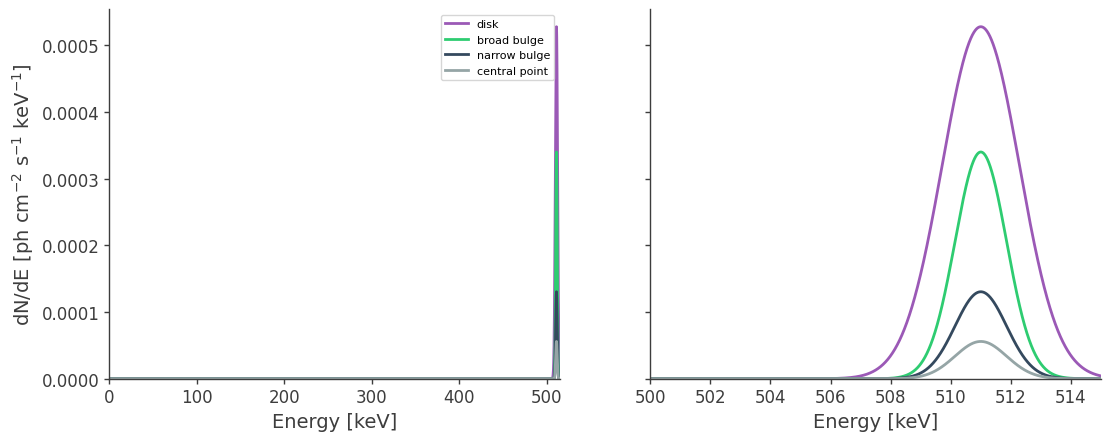

In [56]:
# Plot spectra at 511 and over the entire OPs Spectrum 
energy = np.linspace(0.,520.,10001)*u.keV
energy2 = np.linspace(500.,520.,10001)*u.keV
fig, axs = plt.subplots(ncols=2,sharey=True,figsize=[12.8,4.8])
for label,m in zip(["disk","broad bulge","narrow bulge","central point"],
                   [ModelThickDisk,ModelBroadBulge,ModelNarrowBulge,ModelCentralPoint]):
    dnde = m.spectrum.main.Gaussian(energy)
    axs[0].plot(energy, dnde,label=label)
    axs[1].plot(energy2,m.spectrum.main.Gaussian(energy2),label=label)
axs[0].legend()
axs[0].set_ylabel("dN/dE [$\mathrm{ph \ cm^{-2} \ s^{-1} \ keV^{-1}}$]", fontsize=14)
axs[0].set_xlabel("Energy [keV]", fontsize=14);
axs[1].set_xlabel("Energy [keV]", fontsize=14);
axs[0].set_xlim(0,515)
axs[1].set_xlim(500,515)
plt.ylim(0,);

In [57]:
# Define healpix map matching the detector response:
nside_model = 2**4
scheme='ring'
is_nested = (scheme == 'nested')
coordsys='G'

mBroadBulge = HealpixMap(nside = nside_model, scheme = scheme, dtype = float,coordsys=coordsys)
mNarrowBulge = HealpixMap(nside = nside_model, scheme = scheme, dtype = float,coordsys=coordsys)
mPointBulge = HealpixMap(nside = nside_model, scheme = scheme, dtype = float,coordsys=coordsys)
mThinDisk = HealpixMap(nside = nside_model, scheme=scheme, dtype = float,coordsys=coordsys)
mThickDisk = HealpixMap(nside = nside_model, scheme=scheme, dtype = float,coordsys=coordsys)
coords = mThickDisk.pix2skycoord(range(mThickDisk.npix)) # common among all the galactic maps...

pix_area = mBroadBulge.pixarea().value

# Fill skymap with values from extended source: 
mNarrowBulge[:] = ModelNarrowBulge.spatial_shape(coords.l.deg, coords.b.deg)
mBroadBulge[:] = ModelBroadBulge.spatial_shape(coords.l.deg, coords.b.deg)
mBulge = mBroadBulge + mNarrowBulge #+ mPointBulge

mThinDisk[:] = ModelThinDisk.spatial_shape(coords.l.deg, coords.b.deg)
mThickDisk[:] = ModelThickDisk.spatial_shape(coords.l.deg, coords.b.deg)

# Check normalization:
print("summed map: " + str(np.sum(mBroadBulge)*pix_area))

summed map: 0.9923498352899466


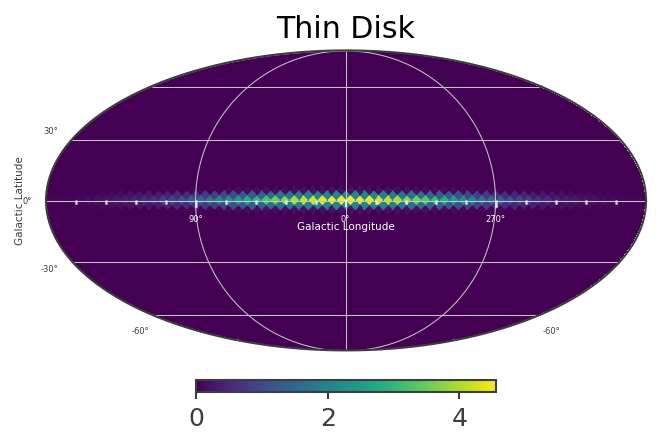

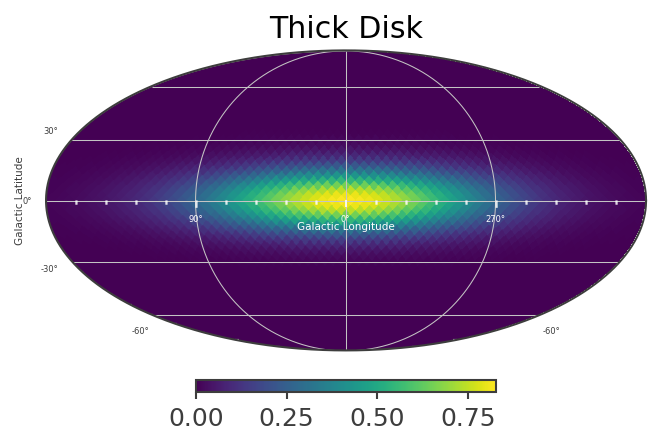

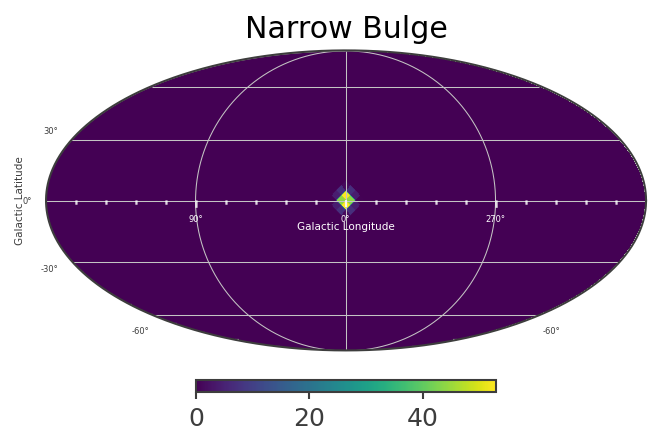

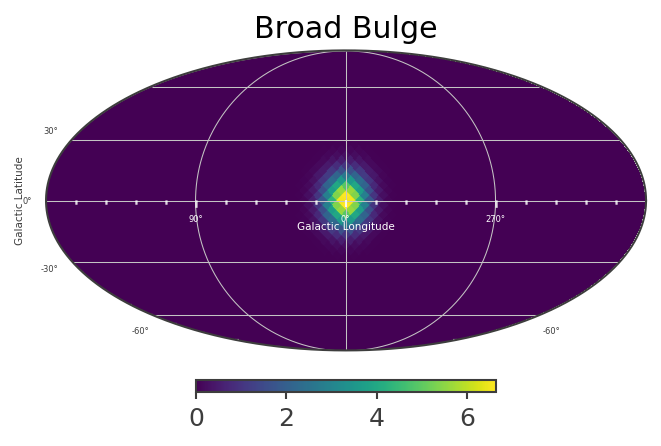

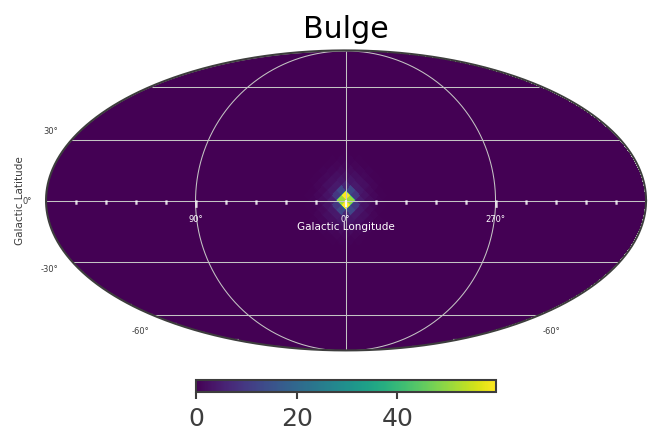

In [58]:
List_of_Maps = [mThinDisk,mThickDisk,mNarrowBulge,mBroadBulge,mBulge]
List_of_Names = ["Thin Disk","Thick Disk","Narrow Bulge","Broad Bulge", 'Bulge']

for n, m in zip(List_of_Names,List_of_Maps):
    plot,ax = m.plot(ax_kw={"coord":"G"})
    ax.grid();
    lon = ax.coords['glon']
    lat = ax.coords['glat']
    lon.set_axislabel('Galactic Longitude',color='white',fontsize=5)
    lat.set_axislabel('Galactic Latitude',fontsize=5)
    lon.display_minor_ticks(True)
    lat.display_minor_ticks(True)
    lon.set_ticks_visible(True)
    lon.set_ticklabel_visible(True)
    lon.set_ticks(color='white',alpha=0.6)
    lat.set_ticks(color='white',alpha=0.6)
    lon.set_ticklabel(color='white',fontsize=4)
    lat.set_ticklabel(fontsize=4)
    lat.set_ticks_visible(True)
    lat.set_ticklabel_visible(True)
    ax.set_title(n)

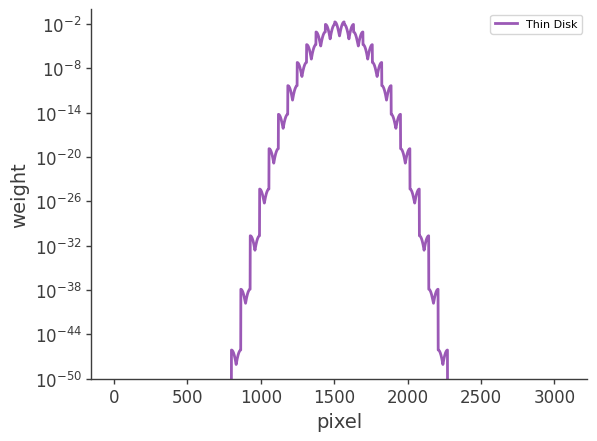

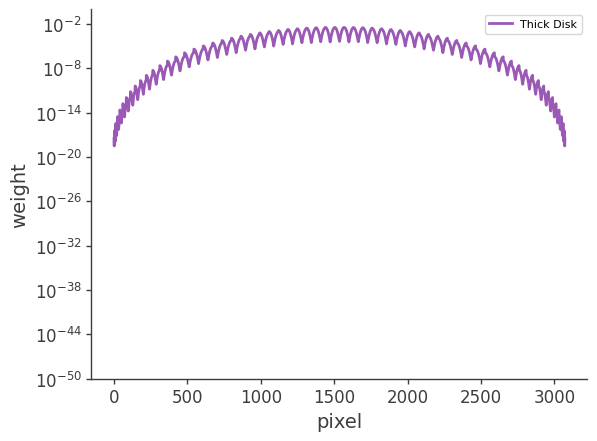

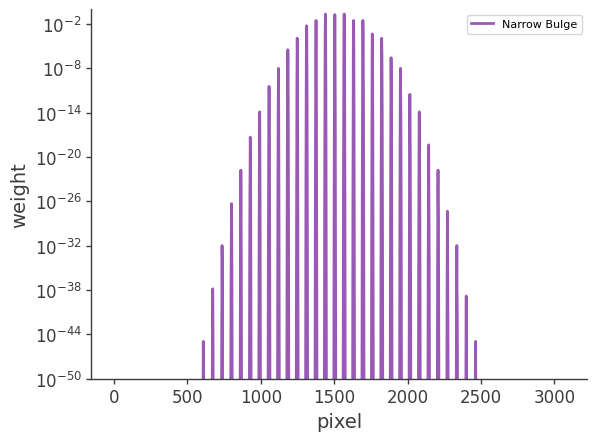

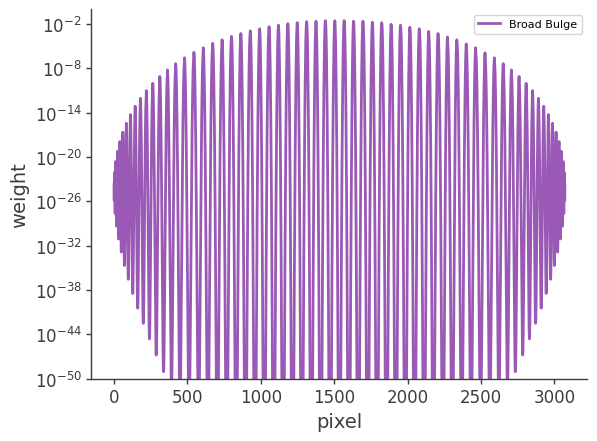

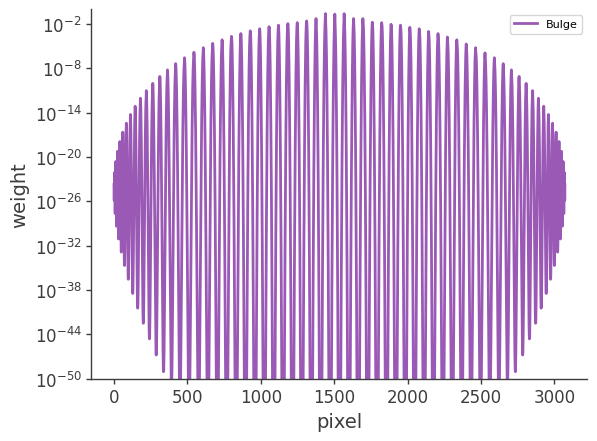

In [59]:
# Plot weights directly
# Note: for extended sources the weights also need to include the pixel area.
for n, m in zip(List_of_Names,List_of_Maps):
    plt.semilogy(m[:]*pix_area,label=n)
    plt.ylabel("weight")
    plt.xlabel("pixel")
    plt.ylim(1e-50,1)
    #plt.label(n)
    plt.legend()
    plt.show()

## Instantiate the COSI 3ML plugin and perform the Likelihood Fit
The following two cells should be run only if not already run in previous examples...

In [60]:
# if not previously loaded in example 1, load the response, ori, and psr: 
response_file = "SMEXv12.511keV.HEALPixO4.binnedimaging.imagingresponse.nonsparse_nside16.area.h5"
response = FullDetectorResponse.open(response_file)
ori = SpacecraftFile.parse_from_file("20280301_3_month.ori")
psr_file = "psr_gal_511_DC2.h5"

In [61]:
# Set background parameter, which is used to fit the amplitude of the background:
bkg_par = Parameter("background_cosi",                                        # background parameter
                    1,                                                        # initial value of parameter
                    min_value=0,                                              # minimum value of parameter
                    max_value=5,                                              # maximum value of parameter
                    delta=0.05,                                               # initial step used by fitting engine
                    desc="Background parameter for cosi")

In [73]:
# Instantiate the COSI 3ML plugin, using combined data for the thin disk
cosi = COSILike("cosi",                                                       # COSI 3ML plugin
                dr = response_file,                                           # detector response
                data = data_combined_thin_disk.binned_data.project('Em', 'Phi', 'PsiChi'),# data (source+background)
                bkg = bg_tot.binned_data.project('Em', 'Phi', 'PsiChi'),       # background model 
                sc_orientation = ori,                                          # spacecraft orientation
                nuisance_param = bkg_par,                                      # background parameter
                precomputed_psr_file = psr_file)                               # full path to precomputed psr file in galactic coordinates (optional)

... loading the pre-computed image response ...
--> done


In [74]:
# add sources to thin disk and thick disk models 
modelThinDisk =  Model(ModelThinDisk, ModelBroadBulge,ModelNarrowBulge,ModelCentralPoint)
modelThickDisk = Model(ModelThickDisk,ModelBroadBulge,ModelNarrowBulge,ModelCentralPoint)

In [75]:
modelThinDisk.display(complete=True)

Model summary:
==============

                  N
Point sources     1
Extended sources  3
Particle sources  0

Free parameters (4):
--------------------

                                         value min_value max_value      unit
thinDisk.spectrum.main.Gaussian.F       0.0017      None      None  s-1 cm-2
broadBulge.spectrum.main.Gaussian.F    0.00073      None      None  s-1 cm-2
narrowBulge.spectrum.main.Gaussian.F   0.00028      None      None  s-1 cm-2
centralPoint.spectrum.main.Gaussian.F  0.00012      None      None  s-1 cm-2

Fixed parameters (21):
---------------------

                                               value min_value max_value unit
thinDisk...lon0                                  0.0       0.0     360.0  deg
thinDisk...lat0                                  0.0     -90.0      90.0  deg
thinDisk.Wide_Asymm_Gaussian_on_sphere.a        60.0       0.0      90.0  deg
thinDisk.Wide_Asymm_Gaussian_on_sphere.e    0.999494       0.0       1.0     
thinDisk...theta                                 0.0     -90.0      90.0  deg
thinDisk.spectrum.main.Gaussian.mu             511.0      None      None  keV
thinDisk.spectrum.main.Gaussian.sigma       1.284797       0.0      None  keV
broadBulge.Gaussian_on_sphere.lon0               0.0       0.0     360.0  deg
broadBulge.Gaussian_on_sphere.lat0               0.0     -90.0      90.0  deg
broadBulge.Gaussian_on_sphere.sigma              8.7       0.0      20.0  deg
broadBulge.spectrum.main.Gaussian.mu           511.0      None      None  keV
broadBulge.spectrum.main.Gaussian.sigma     0.856531       0.0      None  keV
narrowBulge.Gaussian_on_sphere.lon0              0.0       0.0     360.0  deg
narrowBulge.Gaussian_on_sphere.lat0              0.0     -90.0      90.0  deg
narrowBulge.Gaussian_on_sphere.sigma             2.5       0.0      20.0  deg
narrowBulge.spectrum.main.Gaussian.mu          511.0      None      None  keV
narrowBulge.spectrum.main.Gaussian.sigma    0.856531       0.0      None  keV
centralPoint.position.ra                  266.404988       0.0     360.0  deg
centralPoint.position.dec                 -28.936178     -90.0      90.0  deg
centralPoint.spectrum.main.Gaussian.mu         511.0      None      None  keV
centralPoint...sigma                        0.856531       0.0      None  keV

Properties (0):
--------------------

(none)


Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

Linked functions (0):
----------------------

(none)

In [76]:
plugins = DataList(cosi)

In [77]:
like_thin = JointLikelihood(modelThinDisk, plugins, verbose = True) 
#like_thick = JointLikelihood(modelThickDisk, plugins, verbose = False) # compare thick disk model to thin disk data

... Calculating point source responses ...
--> done (source name : centralPoint)
--> all done


13:34:13 INFO      set the minimizer to minuit                                             ]8;id=75872;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=810722;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

In [78]:
like_thin.fit()
#like_thick.fit()


WARNING RuntimeWarning: invalid value encountered in log


WARNING RuntimeWarning: invalid value encountered in log


WARNING RuntimeWarning: invalid value encountered in log


WARNING RuntimeWarning: invalid value encountered in log


WARNING RuntimeWarning: invalid value encountered in log


WARNING RuntimeWarning: invalid value encountered in log


WARNING RuntimeWarning: invalid value encountered in log


WARNING RuntimeWarning: invalid value encountered in log


WARNING RuntimeWarning: invalid value encountered in log



13:50:26 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=167844;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=140617;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#130\130]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

Best fit values:

,result,unit
parameter,,
thinDisk.spectrum.main.Gaussian.F,(1.777 +/- 0.015) x 10^-3,1 / (s cm2)
broadBulge.spectrum.main.Gaussian.F,(3.46 +/- 0.18) x 10^-4,1 / (s cm2)
narrowBulge.spectrum.main.Gaussian.F,(5.37 +/- 0.13) x 10^-4,1 / (s cm2)
centralPoint.spectrum.main.Gaussian.F,(2.33 +/- 0.27) x 10^-5,1 / (s cm2)
background_cosi,1.0307 +/- 0.0030,


Correlation matrix:

1.00,-0.53,0.18,-0.24,-0.35
-0.53,1.00,-0.86,0.06,-0.01
0.18,-0.86,1.00,-0.02,0.03
-0.24,0.06,-0.02,1.00,-0.10
-0.35,-0.01,0.03,-0.10,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,-166864.206475
total,-166864.206475


Values of statistical measures:

,statistical measures
AIC,-333730.41295
BIC,-333728.41295


(                                          value  negative_error  \
 thinDisk.spectrum.main.Gaussian.F      0.001777       -0.000015   
 broadBulge.spectrum.main.Gaussian.F    0.000346       -0.000018   
 narrowBulge.spectrum.main.Gaussian.F   0.000537       -0.000013   
 centralPoint.spectrum.main.Gaussian.F  0.000023       -0.000003   
 background_cosi                        1.030692       -0.003002   
 
                                        positive_error     error         unit  
 thinDisk.spectrum.main.Gaussian.F            0.000015  0.000015  1 / (s cm2)  
 broadBulge.spectrum.main.Gaussian.F          0.000018  0.000018  1 / (s cm2)  
 narrowBulge.spectrum.main.Gaussian.F         0.000013  0.000013  1 / (s cm2)  
 centralPoint.spectrum.main.Gaussian.F        0.000003  0.000003  1 / (s cm2)  
 background_cosi                              0.003014  0.003008               ,
        -log(likelihood)
 cosi     -166864.206475
 total    -166864.206475)

## Results

In [82]:
# thin disk model to data
results_thin = like_thin.results
results_thin.display()

# Print a summary of the optimized model:
print(results_thin.optimized_model["centralPoint"])
print(results_thin.optimized_model["narrowBulge"])
print(results_thin.optimized_model["broadBulge"])
print(results_thin.optimized_model["thinDisk"])

Best fit values:

,result,unit
parameter,,
thinDisk.spectrum.main.Gaussian.F,(1.777 +/- 0.015) x 10^-3,1 / (s cm2)
broadBulge.spectrum.main.Gaussian.F,(3.46 +/- 0.18) x 10^-4,1 / (s cm2)
narrowBulge.spectrum.main.Gaussian.F,(5.37 +/- 0.13) x 10^-4,1 / (s cm2)
centralPoint.spectrum.main.Gaussian.F,(2.33 +/- 0.27) x 10^-5,1 / (s cm2)
background_cosi,1.0307 +/- 0.0030,


Correlation matrix:

1.00,-0.53,0.18,-0.24,-0.35
-0.53,1.00,-0.86,0.06,-0.01
0.18,-0.86,1.00,-0.02,0.03
-0.24,0.06,-0.02,1.00,-0.10
-0.35,-0.01,0.03,-0.10,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,-166864.206475
total,-166864.206475


Values of statistical measures:

,statistical measures
AIC,-333730.41295
BIC,-333728.41295


  * centralPoint (point source):
    * position:
      * ra:
        * value: 266.4049882865447
        * desc: Right Ascension
        * min_value: 0.0
        * max_value: 360.0
        * unit: deg
        * is_normalization: false
      * dec:
        * value: -28.936177761791473
        * desc: Declination
        * min_value: -90.0
        * max_value: 90.0
        * unit: deg
        * is_normalization: false
      * equinox: J2000
    * spectrum:
      * main:
        * Gaussian:
          * F:
            * value: 2.332765415537515e-05
            * desc: Integral between -inf and +inf. Fix this to 1 to obtain a Normal distribution
            * min_value: null
            * max_value: null
            * unit: s-1 cm-2
            * is_normalization: false
          * mu:
            * value: 511.0
            * desc: Central value
            * min_value: null
            * max_value: null
            * unit: keV
            * is_normalization: false
          * sigma:
       

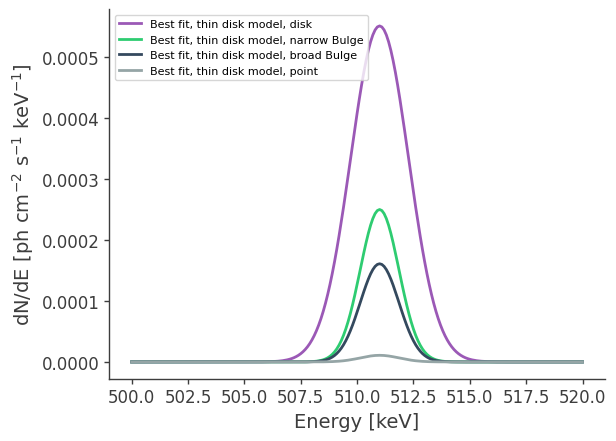

In [85]:
# Best-fit model:
energy = np.linspace(500.,520.,201)*u.keV
flux_thin_disk = results_thin.optimized_model["thinDisk"].spectrum.main.shape(energy)
flux_thin_nB = results_thin.optimized_model["narrowBulge"].spectrum.main.shape(energy)
flux_thin_bB = results_thin.optimized_model["broadBulge"].spectrum.main.shape(energy)
flux_thin_point = results_thin.optimized_model["centralPoint"].spectrum.main.shape(energy)
#flux_thick = results_thick.optimized_model["gaussian"].spectrum.main.shape(energy)

fig,ax = plt.subplots()

ax.plot(energy, flux_thin_disk, label = "Best fit, thin disk model, disk")
ax.plot(energy, flux_thin_nB, label = "Best fit, thin disk model, narrow Bulge")
ax.plot(energy, flux_thin_bB, label = "Best fit, thin disk model, broad Bulge")
ax.plot(energy, flux_thin_point, label = "Best fit, thin disk model, point")
#ax.plot(energy, flux_thick, label = "Best fit - thick disk model")

plt.ylabel("dN/dE [$\mathrm{ph \ cm^{-2} \ s^{-1} \ keV^{-1}}$]", fontsize=14)
plt.xlabel("Energy [keV]", fontsize=14)
ax.legend()

Error: [468.63077581]


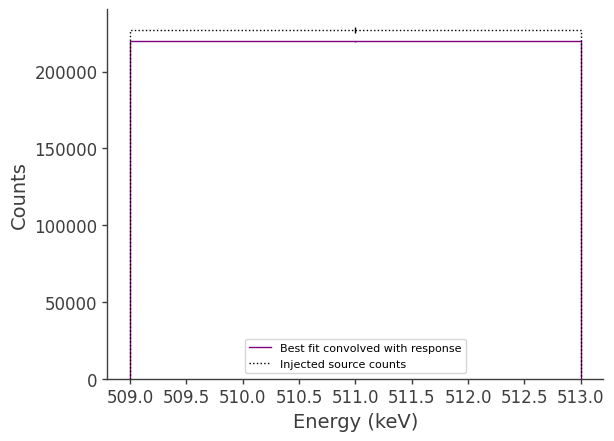

In [86]:
# Get expected counts from likelihood scan (i.e. best-fit convolved with response):
expectation_disk = cosi._expected_counts['thinDisk']
expectation_nB = cosi._expected_counts['narrowBulge']
expectation_bB = cosi._expected_counts['broadBulge']
expectation_point = cosi._expected_counts['centralPoint']
total_expectation = expectation_disk + expectation_nB + expectation_bB + expectation_point 

# Plot:       
fig,ax = plt.subplots()

binned_energy_edges = gal_511_thin_disk.binned_data.axes['Em'].edges.value
binned_energy = gal_511_thin_disk.binned_data.axes['Em'].centers.value

ax.stairs(total_expectation.project('Em').todense().contents, binned_energy_edges, color='purple', label = "Best fit convolved with response")
ax.errorbar(binned_energy, total_expectation.project('Em').todense().contents, yerr=np.sqrt(total_expectation.project('Em').todense().contents), color='purple', linewidth=0, elinewidth=1)
ax.stairs(gal_511_thin_disk.binned_data.project('Em').todense().contents, binned_energy_edges, color = 'black', ls = ":", label = "Injected source counts")
ax.errorbar(binned_energy, gal_511_thin_disk.binned_data.project('Em').todense().contents, yerr=np.sqrt(gal_511.binned_data.project('Em').todense().contents), color='black', linewidth=0, elinewidth=1)

ax.set_xlabel("Energy (keV)")
ax.set_ylabel("Counts")

ax.legend()

# Note: We are plotting the error, but it's very small:
print("Error: " +str(np.sqrt(total_expectation.project('Em').todense().contents)))

Let's also compare the projection onto Psichi:

Text(0.5, 1.0, 'injected counts')

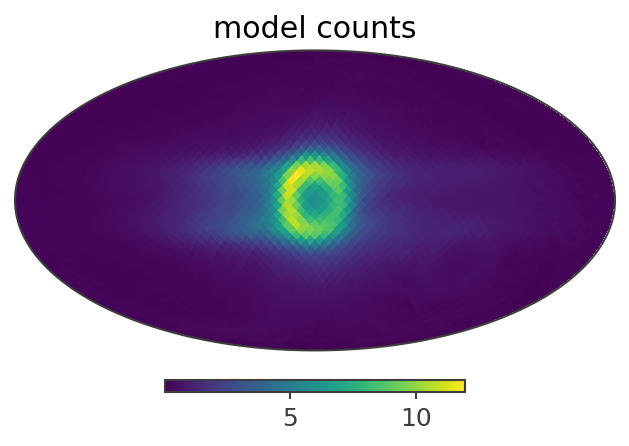

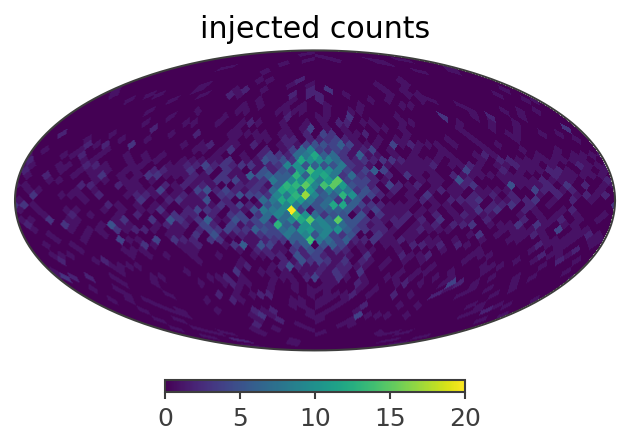

In [87]:
# expected src counts:
ax,plot = total_expectation.slice[{'Em':0, 'Phi':5}].project('PsiChi').plot(ax_kw = {'coord':'G'})
plt.title("model counts")

# injected src counts:
ax,plot = gal_511_thin_disk.binned_data.slice[{'Em':0, 'Phi':5}].project('PsiChi').plot(ax_kw = {'coord':'G'})
plt.title("injected counts")